Data Loading & Cleaning

In [18]:
import pandas as pd
import numpy as np
import time
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import RANSACRegressor
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import HuberRegressor
from sklearn.model_selection import train_test_split, RandomizedSearchCV, cross_val_score
from sklearn.metrics import mean_absolute_error, r2_score, mean_squared_log_error, mean_squared_error
import seaborn as sns
from itertools import combinations
from sklearn.linear_model import RidgeCV, Ridge, Lasso
from sklearn.linear_model import LassoCV
from sklearn.linear_model import ElasticNetCV
from sklearn.linear_model import SGDRegressor
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import Pipeline

path = './data/movies_dataset.csv'

df = pd.read_csv(path)

In [3]:
# GENERAL data pre-processing

#We split the dataset intro train and test, and parameters and target
X = df.drop(columns=['Global_BoxOfficeUSD'])
y = df['Global_BoxOfficeUSD']

# Hacer el split ANTES de cualquier transformación
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.2,       # 20% test
    random_state=42,     # for replicability
    shuffle=True         
)

#We drop the columns that had a high correlation with 'Global_BoxOfficeUSD' as identified during the data cleaning
to_drop_hc = [
    'US_BoxOfficeUSD',       
    'Opening_Day_SalesUSD',  
    'One_Week_SalesUSD'     
]
to_drop_hc = [c for c in to_drop_hc if c in X_train.columns]
if len(to_drop_hc) > 0:
    X_train = X_train.drop(columns=to_drop_hc)
else:
    print("Columns have already been dropped")

#We extract year, month and day from the release date, useful to  detect seasonal patterns
X_train['ReleaseDate'] = pd.to_datetime(X_train['ReleaseDate'], dayfirst=True, errors='coerce')
X_train['ReleaseDate_Year'] = X_train['ReleaseDate'].dt.year
X_train['ReleaseDate_Month'] = X_train['ReleaseDate'].dt.month
X_train['ReleaseDate_Day'] = X_train['ReleaseDate'].dt.day

#Numerical column scaling
cols_to_scale = [
    'BudgetUSD', 
    'NumVotesIMDb', 'NumVotesRT',
    'IMDbRating', 'RottenTomatoesScore',
    'ReleaseDate_Year', 'ReleaseDate_Month', 'ReleaseDate_Day'
]
scaler = StandardScaler()
X_train_scaled = X_train.copy()
X_train_scaled[cols_to_scale] = scaler.fit_transform(X_train[cols_to_scale])

#We also drop some non-numerical columns that are not relevant for specific models
to_drop_n = [
    'MovieID',       
    'Title',  
    'Director',
    'LeadActor',
    'ReleaseYear', #numerical but duplicated, as we will convert ReleaseDate to separate year, month and day columns
    'ReleaseDate'  #already used, to get the year, month and day columns
]
to_drop_n = [c for c in to_drop_n if c in X_train_scaled.columns]
if len(to_drop_n) > 0:
    X_train_numerical = X_train_scaled.drop(columns=to_drop_n)
else:
    print("Columns have already been dropped")

#There are not too many different genres/countries, so they can be useful if we one-hot encode them
X_train_numerical = pd.get_dummies(X_train_numerical, columns=['Genre'], prefix='Genre')
X_train_numerical = pd.get_dummies(X_train_numerical, columns=['Country'], prefix='Country')

#We apply the same transformations to the test set

# Drop same correlated columns
X_test = X_test.drop(columns=to_drop_hc, errors='ignore')

# ReleaseDate → year / month / day
X_test['ReleaseDate'] = pd.to_datetime(X_test['ReleaseDate'], dayfirst=True, errors='coerce')
X_test['ReleaseDate_Year'] = X_test['ReleaseDate'].dt.year
X_test['ReleaseDate_Month'] = X_test['ReleaseDate'].dt.month
X_test['ReleaseDate_Day'] = X_test['ReleaseDate'].dt.day

# Scaling (use transform only!)
X_test_scaled = X_test.copy()
X_test_scaled[cols_to_scale] = scaler.transform(X_test[cols_to_scale])

# Drop the same non-numerical columns
X_test_numerical = X_test_scaled.drop(columns=to_drop_n, errors='ignore')

# One-hot encoding: ensure same columns as train
X_test_numerical = pd.get_dummies(X_test_numerical, columns=['Genre'], prefix='Genre')
X_test_numerical = pd.get_dummies(X_test_numerical, columns=['Country'], prefix='Country')

# Reindex to match train columns
X_test_numerical = X_test_numerical.reindex(columns=X_train_numerical.columns, fill_value=0)

print("Final dataset shape:", X_train_numerical.shape)
X_train_numerical.head()

Final dataset shape: (799999, 26)


,BudgetUSD,IMDbRating,RottenTomatoesScore,NumVotesIMDb,NumVotesRT,ReleaseDate_Year,ReleaseDate_Month,ReleaseDate_Day,Genre_Action,Genre_Comedy,...,Country_Australia,Country_Canada,Country_China,Country_France,Country_Germany,Country_India,Country_Japan,Country_South Korea,Country_UK,Country_USA
566853,-0.241545,0.675644,1.148362,-0.190588,0.638026,-0.312189,1.299563,-0.651791,False,True,...,False,False,False,False,True,False,False,False,False,False
382311,-0.047463,-0.939364,-1.068053,-0.353971,-0.200939,-0.571845,-1.312673,-0.651791,False,False,...,True,False,False,False,False,False,False,False,False,False
241519,-0.306311,-1.141241,-0.840729,-0.276840,-0.234123,0.674506,-0.151679,-0.197554,False,False,...,False,False,False,False,False,False,False,False,False,True
930120,-0.347633,0.810228,0.239064,-0.321399,-0.233175,0.622574,-0.151679,0.483803,False,False,...,False,False,False,False,False,False,False,False,False,True
911069,-0.421552,0.271892,-0.272417,-0.348078,-0.197384,0.310987,-1.602922,0.710922,True,False,...,False,False,False,False,False,False,False,False,False,True


In [31]:
# Sampling of the dataset to optimize heavy models
# Stratifying in quartiles by revenue
y_train_quartiles = pd.qcut(y_train, q=4, labels=False, duplicates='drop')

# Create a subset of 15% of the data
X_subset, _, y_subset, _ = train_test_split(
    X_train_numerical,  
    y_train,
    train_size=0.15,
    stratify=y_train_quartiles,
    random_state=123
)

print(f"\nDatasets for optimization:")
print(f"   Train (whole): {X_train_numerical.shape[0]:,} samples")
print(f"   Subset (15%):   {X_subset.shape[0]:,} samples")
print(f"   Test:           {X_test_numerical.shape[0]:,} samples")

# Verificar representatividad
print(f"\nVerification:")
print(f"   Train - Mean: ${y_train.mean()/1e6:.1f}M, Std: ${y_train.std()/1e6:.1f}M")
print(f"   Subset - Mean: ${y_subset.mean()/1e6:.1f}M, Std: ${y_subset.std()/1e6:.1f}M")


Datasets for optimization:
   Train (whole): 799,999 samples
   Subset (15%):   119,999 samples
   Test:           200,000 samples

Verification:
   Train - Mean: $27.1M, Std: $69.3M
   Subset - Mean: $27.3M, Std: $69.8M


In [4]:
# Single variable data preprocessing

# --- 1. DATA PREPARATION ---
# Define the Target Variable
target = 'Global_BoxOfficeUSD'

# Define X (Predictor) and y (Target)
# For Simple Regression, X must be a DataFrame with a single column (double brackets)
X_simple = df[['BudgetUSD']] 
y = df[target]

print(f"Predictor Variable (X): BudgetUSD")
print(f"Target Variable (y): {target}")

# --- 2. TRAIN / TEST SPLIT ---
# Split 80% for training and 20% for testing
X_train_simple, X_test_simple, y_train_simple, y_test_simple = train_test_split(
    X_simple, 
    y, 
    test_size=0.2, 
    random_state=42
)

# --- 3. SCALING (StandardScaler) ---
# Even for simple regression, it is good practice to scale money values
scaler = StandardScaler()

# Fit only on training data to avoid data leakage ("peeking" at the test set)
X_train_scaled_simple = scaler.fit_transform(X_train_simple)
X_test_scaled_simple = scaler.transform(X_test_simple)

Predictor Variable (X): BudgetUSD
Target Variable (y): Global_BoxOfficeUSD


SIMPLE LINEAR REGRESSION (We will predict the Global_BoxOfficeUSD based on the BudgetUSD)


=== SIMPLE LINEAR REGRESSION RESULTS ===
R2 Score (Accuracy): 0.8039
RMSE (Root Mean Squared Error): $31,298,516.55
MAE (Mean Absolute Error):      $10,837,028.44


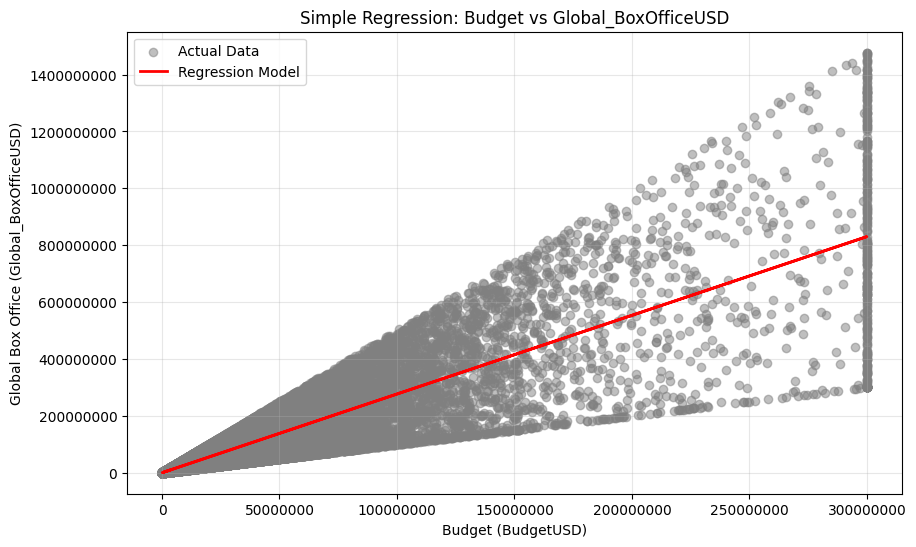


=== EVALUATION REPORT: SIMPLE REGRESSION ===
R2 Score (Train): 0.8013
R2 Score (Test):  0.8039
 STATUS: Healthy model (Good generalization).


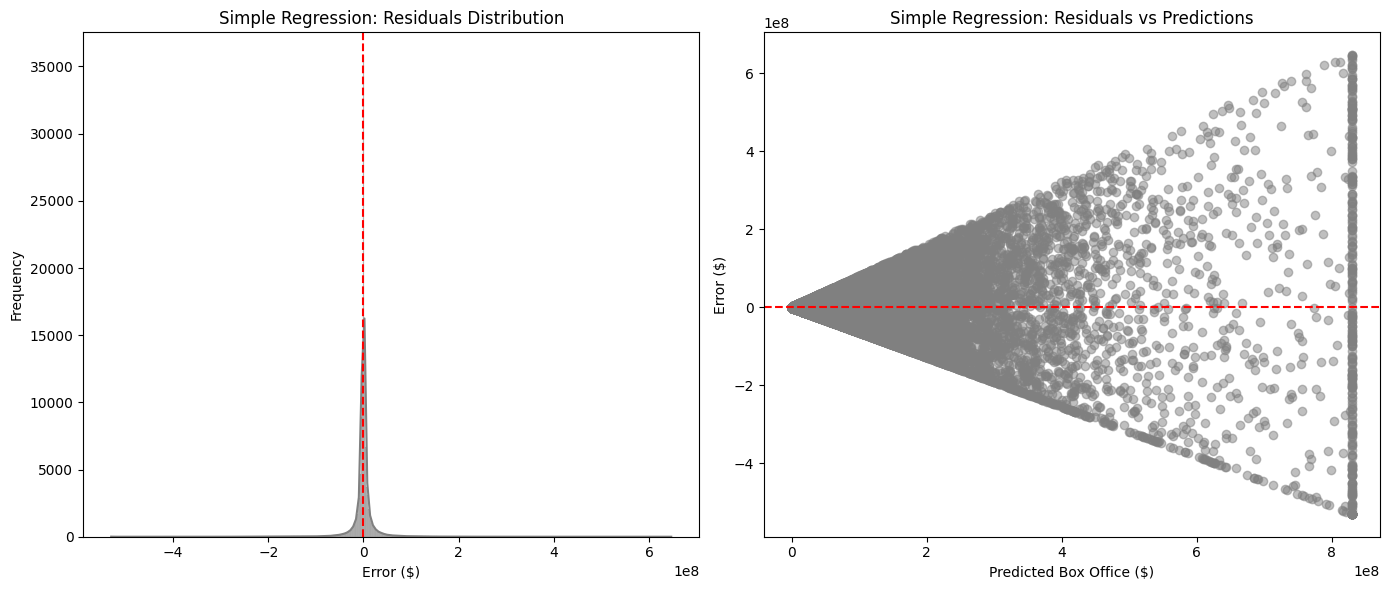

In [5]:
# --- 4. MODEL TRAINING (OLS) ---
simple_model = LinearRegression()
simple_model.fit(X_train_scaled_simple, y_train_simple)

# --- 5. PREDICTION AND EVALUATION ---
y_pred_simple = simple_model.predict(X_test_scaled_simple)

# Calculate metrics
r2 = r2_score(y_test_simple, y_pred_simple)
rmse = np.sqrt(mean_squared_error(y_test_simple, y_pred_simple))
mae = mean_absolute_error(y_test_simple, y_pred_simple)

print("\n=== SIMPLE LINEAR REGRESSION RESULTS ===")
print(f"R2 Score (Accuracy): {r2:.4f}")
print(f"RMSE (Root Mean Squared Error): ${rmse:,.2f}")
print(f"MAE (Mean Absolute Error):      ${mae:,.2f}")

# --- 6. VISUALIZATION ---
plt.figure(figsize=(10, 6))

# Pro Tip: Inverse transform the X-axis to show real Dollars, not standard deviations
X_test_real_dollars = scaler.inverse_transform(X_test_scaled_simple)

# Real data points (Scatter)
plt.scatter(X_test_real_dollars, y_test_simple, color='gray', alpha=0.5, label='Actual Data')

# Prediction line
plt.plot(X_test_real_dollars, y_pred_simple, color='red', linewidth=2, label='Regression Model')

plt.title(f'Simple Regression: Budget vs {target}')
plt.xlabel('Budget (BudgetUSD)')
plt.ylabel('Global Box Office (Global_BoxOfficeUSD)')
plt.legend()
plt.grid(True, alpha=0.3)

# Format axes to avoid scientific notation (e.g., 1e9)
plt.ticklabel_format(style='plain', axis='both') 
plt.show()

#EVALUATION

# --- 7. MODEL EVALUATION (Overfitting & Residuals) ---
# We use the 'simple_model' you just trained

print("\n=== EVALUATION REPORT: SIMPLE REGRESSION ===")

# 1. OVERFITTING CHECK
# Predict on both Train and Test sets to compare performance
y_train_pred_simple = simple_model.predict(X_train_scaled_simple)

# Calculate R2 Scores
r2_train = r2_score(y_train_simple, y_train_pred_simple)
r2_test = r2_score(y_test_simple, y_pred_simple)

print(f"R2 Score (Train): {r2_train:.4f}")
print(f"R2 Score (Test):  {r2_test:.4f}")

# Check the difference
diff = r2_train - r2_test
if diff > 0.10:
    print(f" WARNING: High Overfitting detected (Difference: {diff:.2f}).")
    print("The model explains the training data much better than the test data.")
elif diff < -0.05:
    print(f" Suspicious: Test score is better than Train score.")
else:
    print(f" STATUS: Healthy model (Good generalization).")

# 2. RESIDUALS ANALYSIS
# Calculate errors (Real - Predicted)
residuals = y_test_simple - y_pred_simple

plt.figure(figsize=(14, 6))

# Plot A: Residuals Distribution (Histogram)
# We want a bell curve centered at 0 (Normal Distribution)
plt.subplot(1, 2, 1)
sns.histplot(residuals, kde=True, color='gray')
plt.axvline(x=0, color='red', linestyle='--')
plt.title('Simple Regression: Residuals Distribution')
plt.xlabel('Error ($)')
plt.ylabel('Frequency')

# Plot B: Residuals vs. Predicted (Homoscedasticity)
# We want a random cloud of points. No funnel shapes.
plt.subplot(1, 2, 2)
plt.scatter(y_pred_simple, residuals, alpha=0.5, color='gray')
plt.axhline(y=0, color='red', linestyle='--')
plt.title('Simple Regression: Residuals vs Predictions')
plt.xlabel('Predicted Box Office ($)')
plt.ylabel('Error ($)')

plt.tight_layout()
plt.show()

MULTIPLE LINEAR REGRESSION(We will predict the Global_BoxOfficeUSD based on multiple variables, we will try different algorithms)

In [6]:
print(f"Training Features Shape: {X_train_numerical.shape}")
print(f"Testing Features Shape:  {X_test_numerical.shape}")
print(f"Total Predictors (Columns): {X_train_numerical.shape[1]}")

Training Features Shape: (799999, 26)
Testing Features Shape:  (200000, 26)
Total Predictors (Columns): 26


ORDINARY LEAST SQUARES(OLS)

--- 1. ORDINARY LEAST SQUARES (OLS) ---
R2 Score: 0.8039
RMSE:     $31,298,743.60


C:\Users\jon.palacios\AppData\Local\Temp\ipykernel_13668\1395321701.py:48: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_coefs_original, y=top_coefs_original.index, palette=colors)


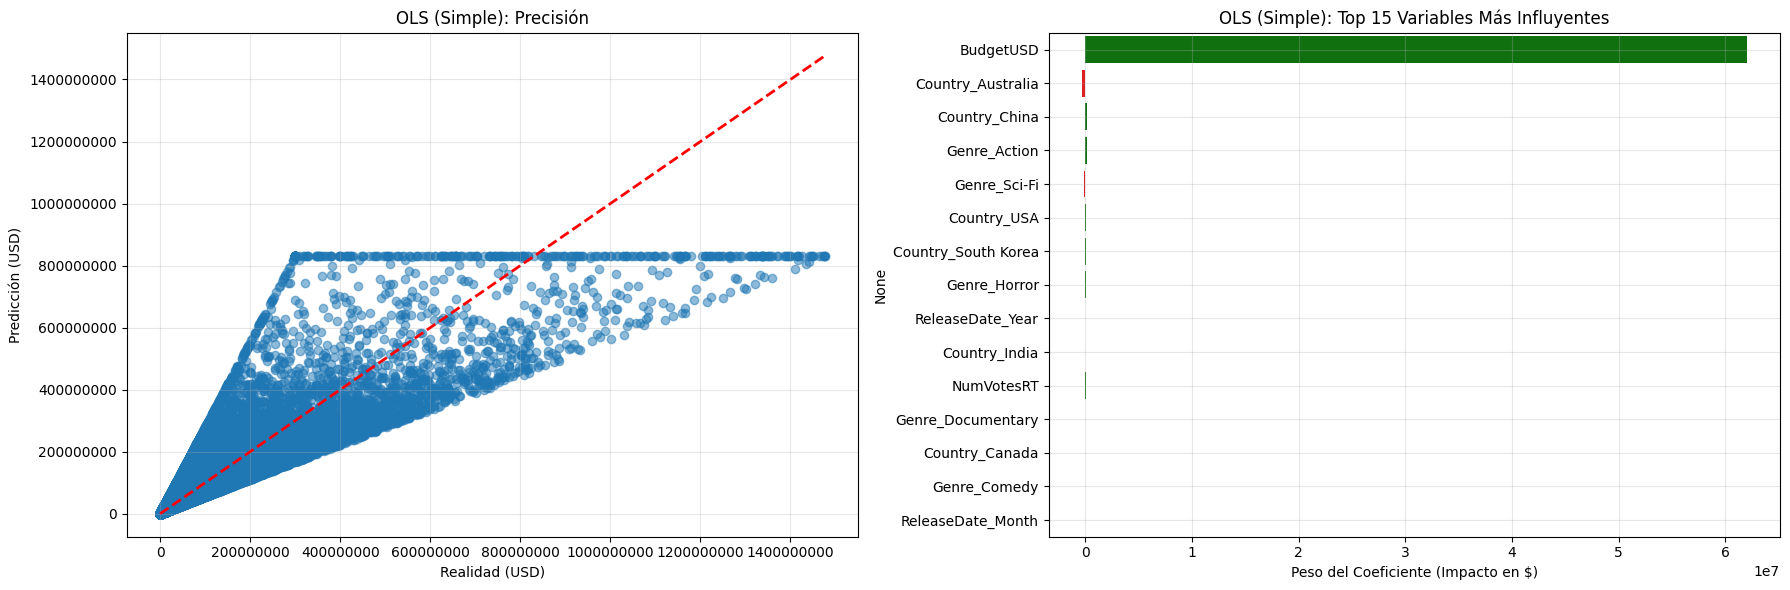


=== EVALUATION REPORT: OLS (Simple) ===
R2 Score (Train): 0.8013
R2 Score (Test):  0.8039
 STATUS: Healthy model (Good generalization).


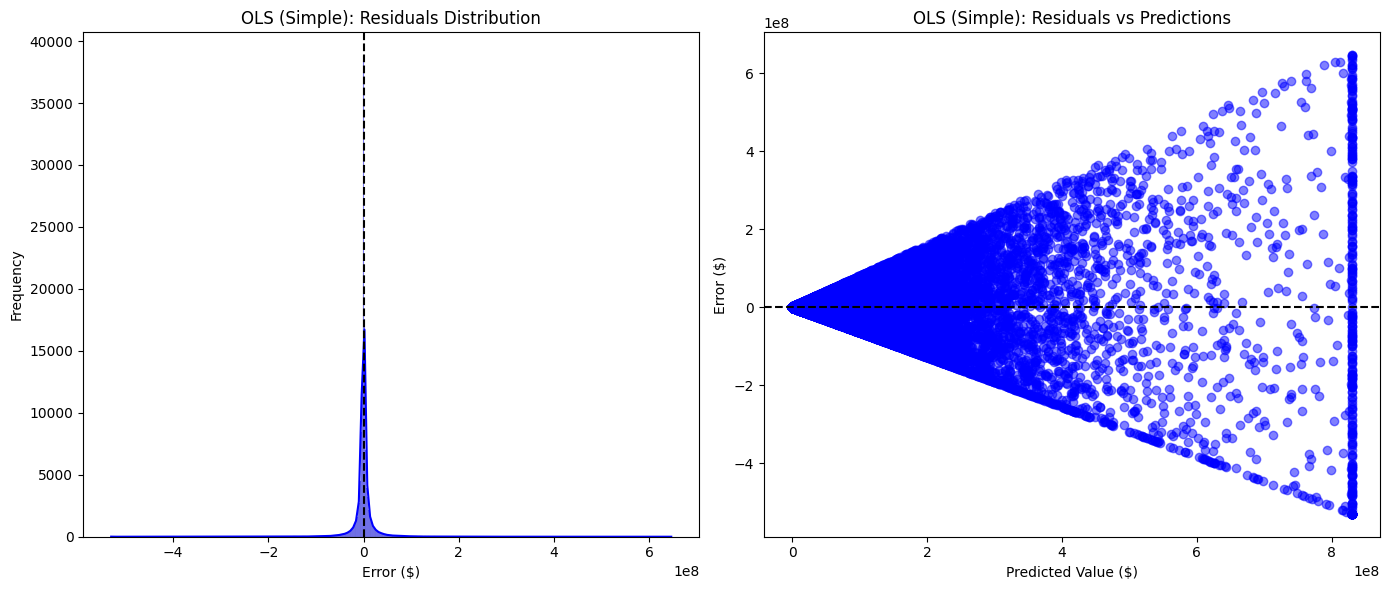


=== PERFORMANCE METRICS ===
R² Score:       0.8039
Adjusted R²:    0.8039
RMSE:           $31,298,743.60
MAE:            $10,839,986.42
MAPE:           57.59%

=== COEFFICIENT INTERPRETATION ===

TOP 5 POSITIVE IMPACT (Increase Box Office):
  • BudgetUSD: +$61,993,870.54
  • Country_China: +$179,747.48
  • Genre_Action: +$140,137.46
  • Country_USA: +$81,557.31
  • Country_South Korea: +$76,086.69

TOP 5 NEGATIVE IMPACT (Decrease Box Office):
  • Country_Australia: $-304,638.50
  • Genre_Sci-Fi: $-130,162.75
  • ReleaseDate_Year: $-62,247.59
  • Country_India: $-52,420.27
  • Genre_Documentary: $-35,004.31

NOTE: Coefficients show the change in Box Office (in $) for a
1-unit increase in the feature (after scaling).


In [7]:
print("--- 1. ORDINARY LEAST SQUARES (OLS) ---")

# A. Initialize the model
ols_model = LinearRegression()

# B. Train the model using the processed training data
ols_model.fit(X_train_numerical, y_train) 

# C. Make predictions on the test set
y_pred_ols = ols_model.predict(X_test_numerical) 

# D. Evaluate metrics
r2_ols = r2_score(y_test, y_pred_ols)
rmse_ols = np.sqrt(mean_squared_error(y_test, y_pred_ols))

print(f"R2 Score: {r2_ols:.4f}")
print(f"RMSE:     ${rmse_ols:,.2f}")

#VISUALIZATION
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns

model = ols_model
name = "OLS (Simple)"
y_pred = model.predict(X_test_numerical) 

plt.figure(figsize=(18, 6))

# Graph1: Reality vs Prediction
plt.subplot(1, 2, 1)
plt.scatter(y_test, y_pred, alpha=0.5, color='tab:blue')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.xlabel('Realidad (USD)')
plt.ylabel('Predicción (USD)')
plt.title(f'{name}: Precisión')
plt.grid(True, alpha=0.3)
plt.ticklabel_format(style='plain', axis='both')

# Graph2: Top Coefficients
plt.subplot(1, 2, 2)
coefs = pd.Series(model.coef_, index=X_test_numerical.columns)
top_coefs = coefs.abs().sort_values(ascending=False).head(15)
top_coefs_original = coefs[top_coefs.index]
colors = ['green' if x > 0 else 'red' for x in top_coefs_original]

sns.barplot(x=top_coefs_original, y=top_coefs_original.index, palette=colors)
plt.title(f'{name}: Top 15 Variables Más Influyentes')
plt.xlabel('Peso del Coeficiente (Impacto en $)')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

#EVALUATION

# --- EVALUATION: OLS (Ordinary Least Squares) ---
model_name = "OLS (Simple)"
current_model = ols_model

print(f"\n=== EVALUATION REPORT: {model_name} ===")

# 1. OVERFITTING CHECK
# Predict on Train set
y_train_pred = current_model.predict(X_train_numerical) 

# Calculate R2 Scores
r2_train = r2_score(y_train, y_train_pred)
r2_test = r2_score(y_test, y_pred_ols)

print(f"R2 Score (Train): {r2_train:.4f}")
print(f"R2 Score (Test):  {r2_test:.4f}")

# Check the difference
diff = r2_train - r2_test
if diff > 0.10:
    print(f" WARNING: High Overfitting detected (Difference: {diff:.2f}).")
elif diff < -0.05:
    print(f" Suspicious: Test score is better than Train score.")
else:
    print(f" STATUS: Healthy model (Good generalization).")

# 2. RESIDUALS ANALYSIS
residuals = y_test - y_pred_ols 

plt.figure(figsize=(14, 6))

# Plot A: Residuals Distribution (Histogram)
plt.subplot(1, 2, 1)
sns.histplot(residuals, kde=True, color='blue')
plt.axvline(x=0, color='black', linestyle='--')
plt.title(f'{model_name}: Residuals Distribution')
plt.xlabel('Error ($)')
plt.ylabel('Frequency')

# Plot B: Residuals vs. Predicted (Homoscedasticity)
plt.subplot(1, 2, 2)
plt.scatter(y_pred_ols, residuals, alpha=0.5, color='blue') 
plt.axhline(y=0, color='black', linestyle='--')
plt.title(f'{model_name}: Residuals vs Predictions')
plt.xlabel('Predicted Value ($)')
plt.ylabel('Error ($)')

plt.tight_layout()
plt.show()

# Additional metrics
mae_ols = mean_absolute_error(y_test, y_pred_ols)
mape_ols = np.mean(np.abs((y_test - y_pred_ols) / y_test)) * 100

# Adjusted R²
n_samples = X_test_numerical.shape[0]
n_features = X_test_numerical.shape[1]
adj_r2_ols = 1 - (1 - r2_ols) * (n_samples - 1) / (n_samples - n_features - 1)

print(f"\n=== PERFORMANCE METRICS ===")
print(f"R² Score:       {r2_ols:.4f}")
print(f"Adjusted R²:    {adj_r2_ols:.4f}")
print(f"RMSE:           ${rmse_ols:,.2f}")
print(f"MAE:            ${mae_ols:,.2f}")
print(f"MAPE:           {mape_ols:.2f}%")


print("\n=== COEFFICIENT INTERPRETATION ===")

# Get coefficients
coefs = pd.Series(ols_model.coef_, index=X_train_numerical.columns)

# Top 5 positive impact
top_positive = coefs.nlargest(5)
print("\nTOP 5 POSITIVE IMPACT (Increase Box Office):")
for feature, coef in top_positive.items():
    print(f"  • {feature}: +${coef:,.2f}")

# Top 5 negative impact
top_negative = coefs.nsmallest(5)
print("\nTOP 5 NEGATIVE IMPACT (Decrease Box Office):")
for feature, coef in top_negative.items():
    print(f"  • {feature}: ${coef:,.2f}")

# Interpretation note
print("\nNOTE: Coefficients show the change in Box Office (in $) for a")
print("1-unit increase in the feature (after scaling).")

RIDGE REGRESSION(L2 REGULARIZATION)


--- 2. RIDGE REGRESSION (L2) ---
R2 Score:   0.8039
RMSE:       $31,298,796.94
Best Alpha: 100.0


C:\Users\asier.vinos\AppData\Local\Temp\ipykernel_22232\647418970.py:43: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_coefs_original, y=top_coefs_original.index, palette=colors)


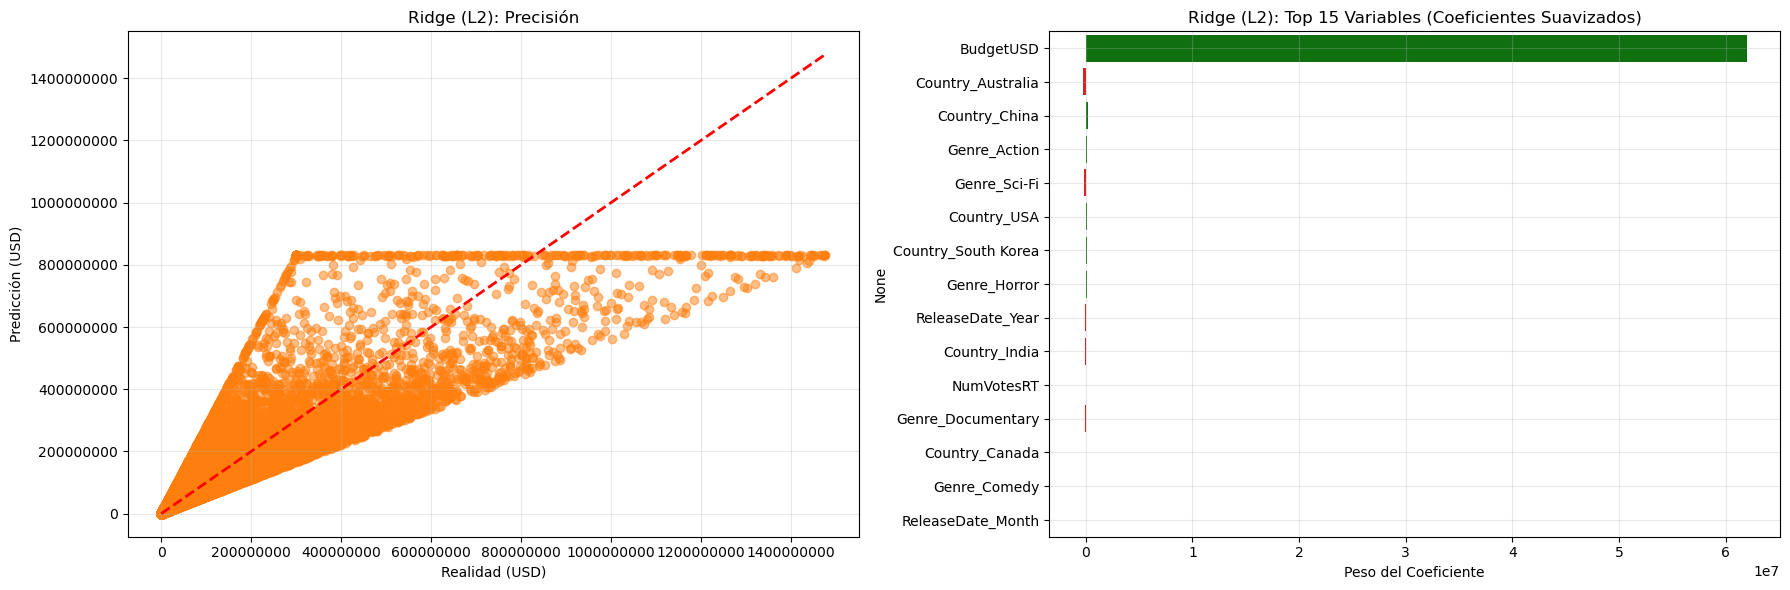


=== EVALUATION REPORT: Ridge (L2) ===
R2 Score (Train): 0.8013
R2 Score (Test):  0.8039
 STATUS: Healthy model (Good generalization).


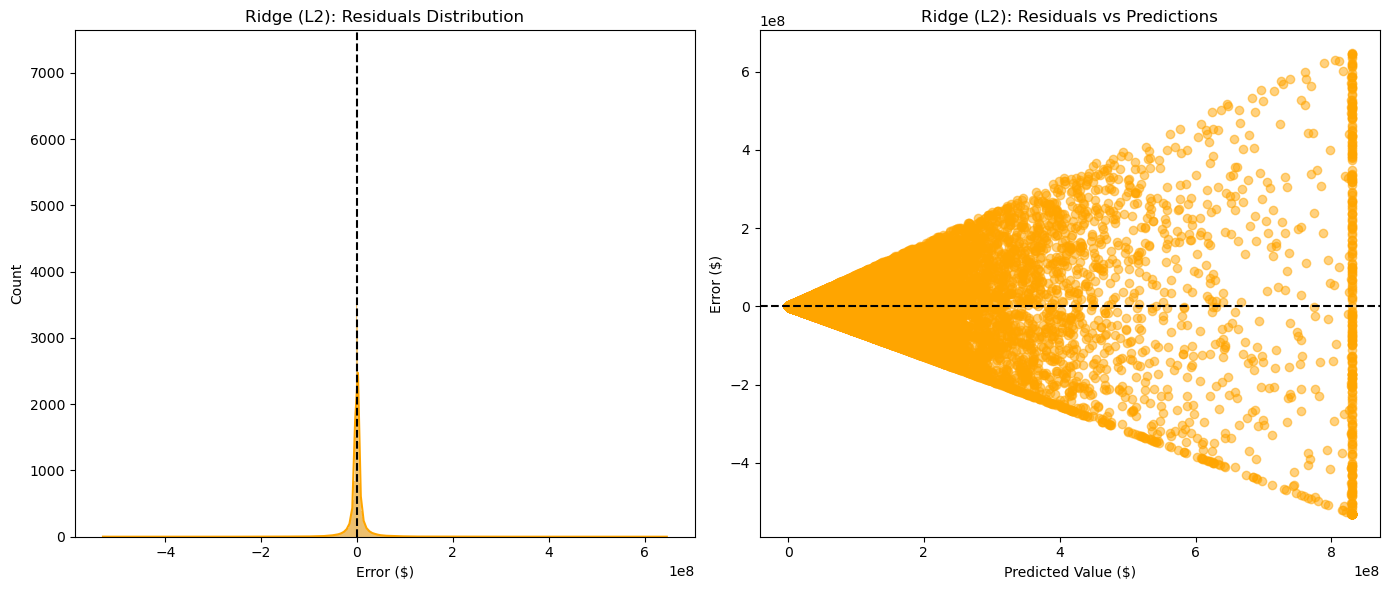


=== PERFORMANCE METRICS ===
R² Score:       0.8039
Adjusted R²:    0.8039
RMSE:           $31,298,796.94
MAE:            $10,840,051.29
MAPE:           57.65%

=== COEFFICIENT INTERPRETATION ===

TOP 5 POSITIVE IMPACT (Increase Box Office):
  • BudgetUSD: +$61,986,121.44
  • Country_China: +$179,031.12
  • Genre_Action: +$139,907.63
  • Country_USA: +$81,551.59
  • Country_South Korea: +$75,183.96

TOP 5 NEGATIVE IMPACT (Decrease Box Office):
  • Country_Australia: $-303,344.46
  • Genre_Sci-Fi: $-129,858.66
  • ReleaseDate_Year: $-62,236.19
  • Country_India: $-52,244.30
  • Genre_Documentary: $-34,869.02

NOTE: Coefficients show the change in Box Office (in $) for a
1-unit increase in the feature (after scaling).


In [15]:
print("\n--- 2. RIDGE REGRESSION (L2) ---")

# A. Initialize Ridge with Cross-Validation (CV)
ridge_model = RidgeCV(alphas=[0.1, 1.0, 10.0, 50.0, 100.0])

# B. Train
ridge_model.fit(X_train_numerical, y_train) 

# C. Predict
y_pred_ridge = ridge_model.predict(X_test_numerical) 

# D. Evaluate
r2_ridge = r2_score(y_test, y_pred_ridge)
rmse_ridge = np.sqrt(mean_squared_error(y_test, y_pred_ridge))

print(f"R2 Score:   {r2_ridge:.4f}")
print(f"RMSE:       ${rmse_ridge:,.2f}")
print(f"Best Alpha: {ridge_model.alpha_}")

#VISUALIZATION
model = ridge_model
name = "Ridge (L2)"

plt.figure(figsize=(18, 6))

# Graph1: Reality vs Prediction
plt.subplot(1, 2, 1)
plt.scatter(y_test, y_pred_ridge, alpha=0.5, color='tab:orange') 
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.xlabel('Realidad (USD)')
plt.ylabel('Predicción (USD)')
plt.title(f'{name}: Precisión')
plt.grid(True, alpha=0.3)
plt.ticklabel_format(style='plain', axis='both')

# Graph2: Top Coefficients
plt.subplot(1, 2, 2)
coefs = pd.Series(model.coef_, index=X_test_numerical.columns) 
top_coefs = coefs.abs().sort_values(ascending=False).head(15)
top_coefs_original = coefs[top_coefs.index]
colors = ['green' if x > 0 else 'red' for x in top_coefs_original]

sns.barplot(x=top_coefs_original, y=top_coefs_original.index, palette=colors)
plt.title(f'{name}: Top 15 Variables (Coeficientes Suavizados)')
plt.xlabel('Peso del Coeficiente')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

#EVALUATION
# --- EVALUATION: RIDGE REGRESSION ---
model_name = "Ridge (L2)"
current_model = ridge_model

print(f"\n=== EVALUATION REPORT: {model_name} ===")

# 1. OVERFITTING CHECK
y_train_pred = current_model.predict(X_train_numerical)

r2_train = r2_score(y_train, y_train_pred)
r2_test = r2_score(y_test, y_pred_ridge)

print(f"R2 Score (Train): {r2_train:.4f}")
print(f"R2 Score (Test):  {r2_test:.4f}")

diff = r2_train - r2_test
if diff > 0.10:
    print(f" WARNING: High Overfitting detected (Difference: {diff:.2f}).")
else:
    print(f" STATUS: Healthy model (Good generalization).")

# 2. RESIDUALS ANALYSIS
residuals = y_test - y_pred_ridge 

plt.figure(figsize=(14, 6))

# Plot A: Distribution
plt.subplot(1, 2, 1)
sns.histplot(residuals, kde=True, color='orange')
plt.axvline(x=0, color='black', linestyle='--')
plt.title(f'{model_name}: Residuals Distribution')
plt.xlabel('Error ($)')

# Plot B: Residuals vs Predicted
plt.subplot(1, 2, 2)
plt.scatter(y_pred_ridge, residuals, alpha=0.5, color='orange') 
plt.axhline(y=0, color='black', linestyle='--')
plt.title(f'{model_name}: Residuals vs Predictions')
plt.xlabel('Predicted Value ($)')
plt.ylabel('Error ($)')

plt.tight_layout()
plt.show()

# Additional metrics
mae_ridge = mean_absolute_error(y_test, y_pred_ridge)
mape_ridge = np.mean(np.abs((y_test - y_pred_ridge) / y_test)) * 100

# Adjusted R²
n_samples = X_test_numerical.shape[0]
n_features = X_test_numerical.shape[1]
adj_r2_ridge = 1 - (1 - r2_ridge) * (n_samples - 1) / (n_samples - n_features - 1)

print(f"\n=== PERFORMANCE METRICS ===")
print(f"R² Score:       {r2_ridge:.4f}")
print(f"Adjusted R²:    {adj_r2_ridge:.4f}")
print(f"RMSE:           ${rmse_ridge:,.2f}")
print(f"MAE:            ${mae_ridge:,.2f}")
print(f"MAPE:           {mape_ridge:.2f}%")


print("\n=== COEFFICIENT INTERPRETATION ===")

# Get coefficients
coefs = pd.Series(ridge_model.coef_, index=X_train_numerical.columns)

# Top 5 positive impact
top_positive = coefs.nlargest(5)
print("\nTOP 5 POSITIVE IMPACT (Increase Box Office):")
for feature, coef in top_positive.items():
    print(f"  • {feature}: +${coef:,.2f}")

# Top 5 negative impact
top_negative = coefs.nsmallest(5)
print("\nTOP 5 NEGATIVE IMPACT (Decrease Box Office):")
for feature, coef in top_negative.items():
    print(f"  • {feature}: ${coef:,.2f}")

# Interpretation note
print("\nNOTE: Coefficients show the change in Box Office (in $) for a")
print("1-unit increase in the feature (after scaling).")

LASSO REGRESSION


--- 3. LASSO REGRESSION ---
R2 Score:   0.8039
RMSE:       $31,299,010.06
Features eliminated: 24 out of 26


C:\Users\asier.vinos\AppData\Local\Temp\ipykernel_22232\1944961414.py:48: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_coefs_original, y=top_coefs_original.index, palette=colors)


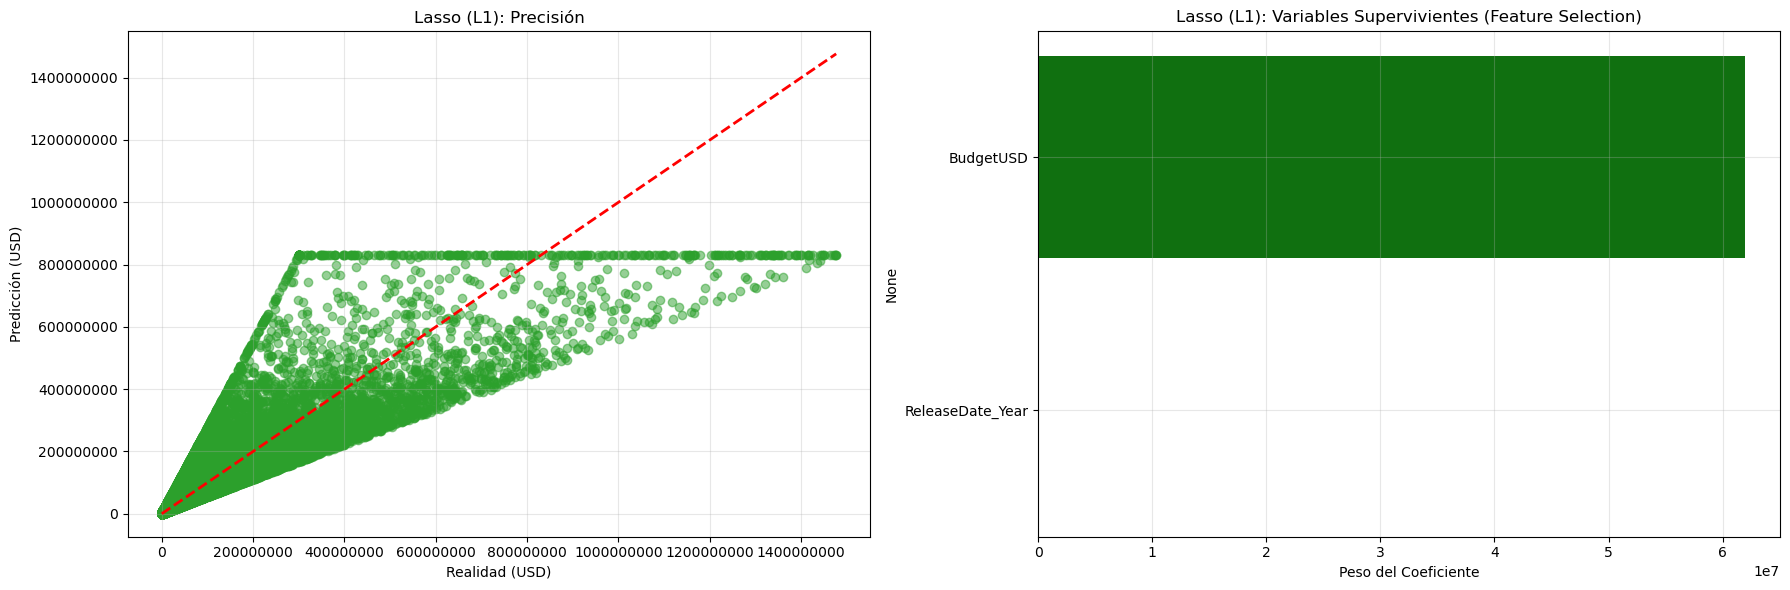

Lasso eliminó 24 variables irrelevantes.

=== EVALUATION REPORT: Lasso (L1) ===
R2 Score (Train): 0.8013
R2 Score (Test):  0.8039
 STATUS: Healthy model (Good generalization).


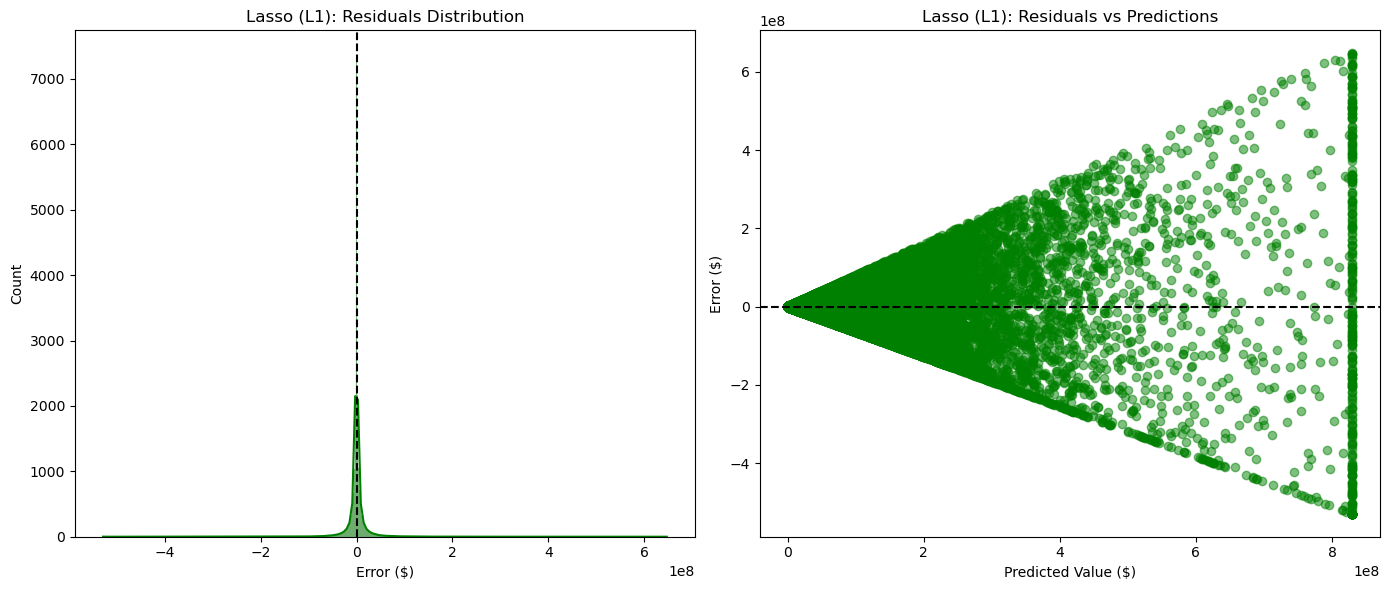


=== PERFORMANCE METRICS ===
R² Score:       0.8039
Adjusted R²:    0.8039
RMSE:           $31,299,010.06
MAE:            $10,837,739.67
MAPE:           57.73%

=== COEFFICIENT INTERPRETATION ===

TOP 5 POSITIVE IMPACT (Increase Box Office):
  • BudgetUSD: +$61,931,535.22
  • IMDbRating: +$0.00
  • RottenTomatoesScore: +$0.00
  • NumVotesIMDb: +$0.00
  • NumVotesRT: +$0.00

TOP 5 NEGATIVE IMPACT (Decrease Box Office):
  • ReleaseDate_Year: $-187.31
  • IMDbRating: $0.00
  • RottenTomatoesScore: $0.00
  • NumVotesIMDb: $0.00
  • NumVotesRT: $0.00

NOTE: Coefficients show the change in Box Office (in $) for a
1-unit increase in the feature (after scaling).


In [16]:
print("\n--- 3. LASSO REGRESSION ---")

# A. Initialize Lasso with CV
lasso_model = LassoCV(cv=5, random_state=42, max_iter=10000)

# B. Train
lasso_model.fit(X_train_numerical, y_train) 

# C. Predict
y_pred_lasso = lasso_model.predict(X_test_numerical) 

# D. Evaluate
r2_lasso = r2_score(y_test, y_pred_lasso)
rmse_lasso = np.sqrt(mean_squared_error(y_test, y_pred_lasso))

# Count how many features were ignored (coefficient became 0)
params_zero = np.sum(lasso_model.coef_ == 0)
total_params = len(lasso_model.coef_)

print(f"R2 Score:   {r2_lasso:.4f}")
print(f"RMSE:       ${rmse_lasso:,.2f}")
print(f"Features eliminated: {params_zero} out of {total_params}")

#VISUALIZATION
model = lasso_model
name = "Lasso (L1)"

plt.figure(figsize=(18, 6))

# Graph1: Reality vs Prediction
plt.subplot(1, 2, 1)
plt.scatter(y_test, y_pred_lasso, alpha=0.5, color='tab:green') 
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.xlabel('Realidad (USD)')
plt.ylabel('Predicción (USD)')
plt.title(f'{name}: Precisión')
plt.grid(True, alpha=0.3)
plt.ticklabel_format(style='plain', axis='both')

# Graph2: Top Coefficients
plt.subplot(1, 2, 2)
coefs = pd.Series(model.coef_, index=X_test_numerical.columns) 
coefs_active = coefs[coefs != 0]
top_coefs = coefs_active.abs().sort_values(ascending=False).head(15)
top_coefs_original = coefs_active[top_coefs.index]
colors = ['green' if x > 0 else 'red' for x in top_coefs_original]

sns.barplot(x=top_coefs_original, y=top_coefs_original.index, palette=colors)
plt.title(f'{name}: Variables Supervivientes (Feature Selection)')
plt.xlabel('Peso del Coeficiente')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"Lasso eliminó {len(coefs) - len(coefs_active)} variables irrelevantes.")

#EVALUATION
# --- EVALUATION: LASSO REGRESSION ---
model_name = "Lasso (L1)"
current_model = lasso_model

print(f"\n=== EVALUATION REPORT: {model_name} ===")

# 1. OVERFITTING CHECK
y_train_pred = current_model.predict(X_train_numerical) 

r2_train = r2_score(y_train, y_train_pred)
r2_test = r2_score(y_test, y_pred_lasso) 

print(f"R2 Score (Train): {r2_train:.4f}")
print(f"R2 Score (Test):  {r2_test:.4f}")

diff = r2_train - r2_test
if diff > 0.10:
    print(f" WARNING: High Overfitting detected (Difference: {diff:.2f}).")
else:
    print(f" STATUS: Healthy model (Good generalization).")

# 2. RESIDUALS ANALYSIS
residuals = y_test - y_pred_lasso 

plt.figure(figsize=(14, 6))

# Plot A: Distribution
plt.subplot(1, 2, 1)
sns.histplot(residuals, kde=True, color='green')
plt.axvline(x=0, color='black', linestyle='--')
plt.title(f'{model_name}: Residuals Distribution')
plt.xlabel('Error ($)')

# Plot B: Residuals vs Predicted
plt.subplot(1, 2, 2)
plt.scatter(y_pred_lasso, residuals, alpha=0.5, color='green') 
plt.axhline(y=0, color='black', linestyle='--')
plt.title(f'{model_name}: Residuals vs Predictions')
plt.xlabel('Predicted Value ($)')
plt.ylabel('Error ($)')

plt.tight_layout()
plt.show()

# Additional metrics
mae_lasso = mean_absolute_error(y_test, y_pred_lasso)
mape_lasso = np.mean(np.abs((y_test - y_pred_lasso) / y_test)) * 100

# Adjusted R²
n_samples = X_test_numerical.shape[0]
n_features = X_test_numerical.shape[1]
adj_r2_lasso = 1 - (1 - r2_lasso) * (n_samples - 1) / (n_samples - n_features - 1)

print(f"\n=== PERFORMANCE METRICS ===")
print(f"R² Score:       {r2_lasso:.4f}")
print(f"Adjusted R²:    {adj_r2_lasso:.4f}")
print(f"RMSE:           ${rmse_lasso:,.2f}")
print(f"MAE:            ${mae_lasso:,.2f}")
print(f"MAPE:           {mape_lasso:.2f}%")


print("\n=== COEFFICIENT INTERPRETATION ===")

# Get coefficients
coefs = pd.Series(lasso_model.coef_, index=X_train_numerical.columns)

# Top 5 positive impact
top_positive = coefs.nlargest(5)
print("\nTOP 5 POSITIVE IMPACT (Increase Box Office):")
for feature, coef in top_positive.items():
    print(f"  • {feature}: +${coef:,.2f}")

# Top 5 negative impact
top_negative = coefs.nsmallest(5)
print("\nTOP 5 NEGATIVE IMPACT (Decrease Box Office):")
for feature, coef in top_negative.items():
    print(f"  • {feature}: ${coef:,.2f}")

# Interpretation note
print("\nNOTE: Coefficients show the change in Box Office (in $) for a")
print("1-unit increase in the feature (after scaling).")

ELASTIC NET REGRESSION


--- 4. ELASTIC NET ---
R2 Score:      0.0025
RMSE:          $70,594,700.07
Best L1 Ratio: 0.99


C:\Users\asier.vinos\AppData\Local\Temp\ipykernel_22232\3777277572.py:43: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_coefs_original, y=top_coefs_original.index, palette=colors)


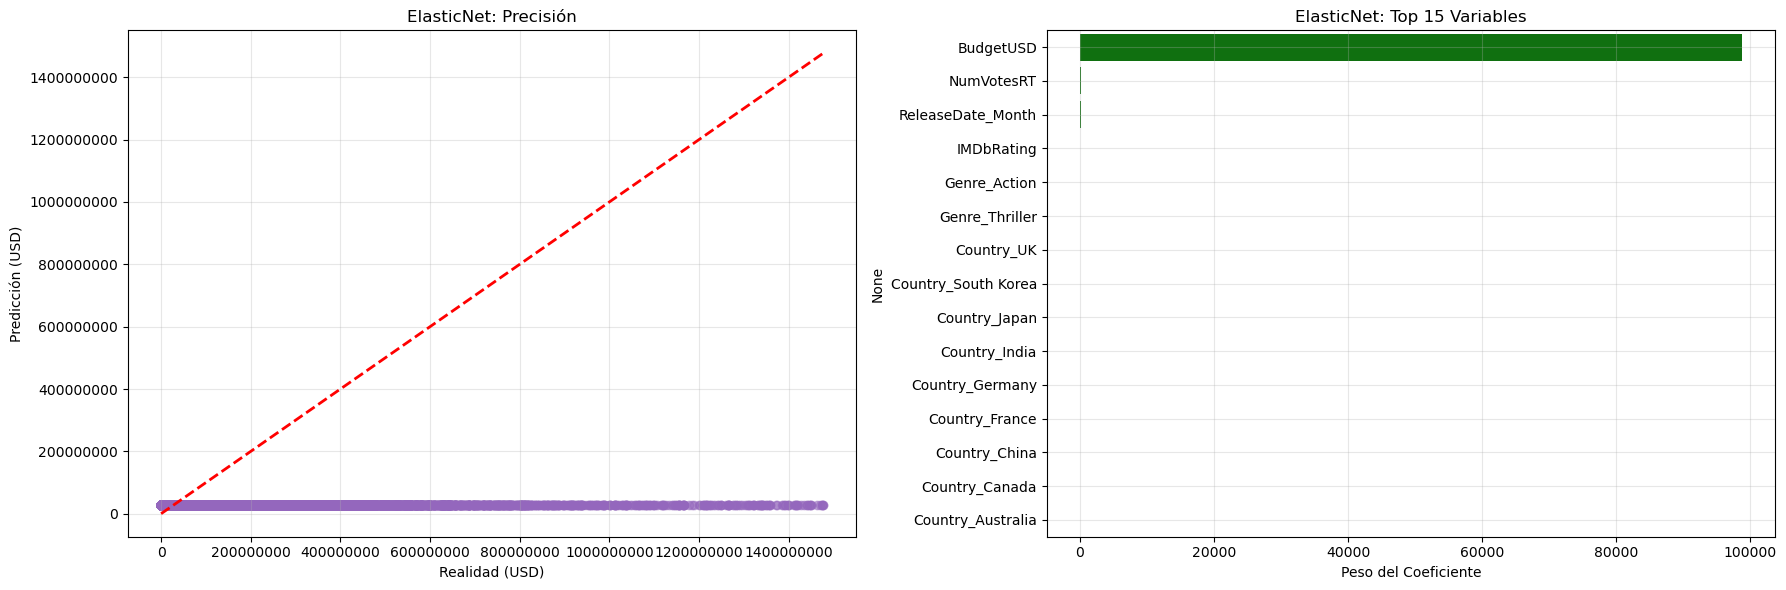


=== EVALUATION REPORT: ElasticNet ===
R2 Score (Train): 0.0026
R2 Score (Test):  0.0025
 STATUS: Healthy model (Good generalization).


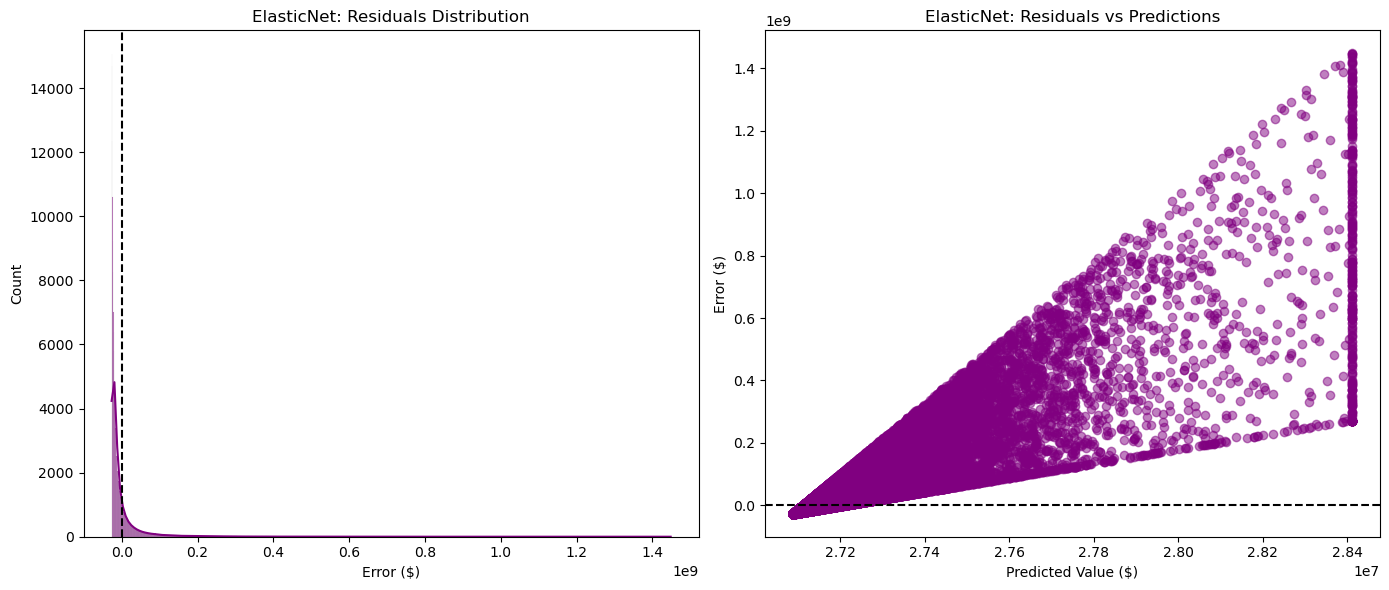


=== PERFORMANCE METRICS ===
R² Score:       0.0025
Adjusted R²:    0.8039
RMSE:           $70,594,700.07
MAE:            $30,793,690.58
MAPE:           1003.18%

=== COEFFICIENT INTERPRETATION ===

TOP 5 POSITIVE IMPACT (Increase Box Office):
  • BudgetUSD: +$98,743.31
  • NumVotesRT: +$150.24
  • ReleaseDate_Month: +$89.45
  • IMDbRating: +$62.44
  • RottenTomatoesScore: +$0.00

TOP 5 NEGATIVE IMPACT (Decrease Box Office):
  • Genre_Action: $-12.55
  • RottenTomatoesScore: $0.00
  • NumVotesIMDb: $0.00
  • ReleaseDate_Year: $-0.00
  • ReleaseDate_Day: $-0.00

NOTE: Coefficients show the change in Box Office (in $) for a
1-unit increase in the feature (after scaling).


In [17]:
print("\n--- 4. ELASTIC NET ---")

# A. Initialize ElasticNet with CV
elastic_model = ElasticNetCV(l1_ratio=[.1, .5, .7, .9, .95, .99], cv=5, random_state=42, max_iter=10000)

# B. Train
elastic_model.fit(X_train_numerical, y_train) 

# C. Predict
y_pred_elastic = elastic_model.predict(X_test_numerical) 

# D. Evaluate
r2_elastic = r2_score(y_test, y_pred_elastic)
rmse_elastic = np.sqrt(mean_squared_error(y_test, y_pred_elastic))

print(f"R2 Score:      {r2_elastic:.4f}")
print(f"RMSE:          ${rmse_elastic:,.2f}")
print(f"Best L1 Ratio: {elastic_model.l1_ratio_}")

#VISUALIZATION
model = elastic_model
name = "ElasticNet"

plt.figure(figsize=(18, 6))

# Graph1: Reality vs Prediction
plt.subplot(1, 2, 1)
plt.scatter(y_test, y_pred_elastic, alpha=0.5, color='tab:purple') 
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.xlabel('Realidad (USD)')
plt.ylabel('Predicción (USD)')
plt.title(f'{name}: Precisión')
plt.grid(True, alpha=0.3)
plt.ticklabel_format(style='plain', axis='both')

# Graph2: Top Coefficients
plt.subplot(1, 2, 2)
coefs = pd.Series(model.coef_, index=X_test_numerical.columns) 
top_coefs = coefs.abs().sort_values(ascending=False).head(15)
top_coefs_original = coefs[top_coefs.index]
colors = ['green' if x > 0 else 'red' for x in top_coefs_original]

sns.barplot(x=top_coefs_original, y=top_coefs_original.index, palette=colors)
plt.title(f'{name}: Top 15 Variables')
plt.xlabel('Peso del Coeficiente')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

#EVALUATION
# --- EVALUATION: ELASTIC NET ---
model_name = "ElasticNet"
current_model = elastic_model

print(f"\n=== EVALUATION REPORT: {model_name} ===")

# 1. OVERFITTING CHECK
y_train_pred = current_model.predict(X_train_numerical)  

r2_train = r2_score(y_train, y_train_pred)
r2_test = r2_score(y_test, y_pred_elastic) 

print(f"R2 Score (Train): {r2_train:.4f}")
print(f"R2 Score (Test):  {r2_test:.4f}")

diff = r2_train - r2_test
if diff > 0.10:
    print(f" WARNING: High Overfitting detected (Difference: {diff:.2f}).")
else:
    print(f" STATUS: Healthy model (Good generalization).")

# 2. RESIDUALS ANALYSIS
residuals = y_test - y_pred_elastic 

plt.figure(figsize=(14, 6))

# Plot A: Distribution
plt.subplot(1, 2, 1)
sns.histplot(residuals, kde=True, color='purple')
plt.axvline(x=0, color='black', linestyle='--')
plt.title(f'{model_name}: Residuals Distribution')
plt.xlabel('Error ($)')

# Plot B: Residuals vs Predicted
plt.subplot(1, 2, 2)
plt.scatter(y_pred_elastic, residuals, alpha=0.5, color='purple')
plt.axhline(y=0, color='black', linestyle='--')
plt.title(f'{model_name}: Residuals vs Predictions')
plt.xlabel('Predicted Value ($)')
plt.ylabel('Error ($)')

plt.tight_layout()
plt.show()

# Additional metrics
mae_elastic = mean_absolute_error(y_test, y_pred_elastic)
mape_elastic = np.mean(np.abs((y_test - y_pred_elastic) / y_test)) * 100

# Adjusted R²
n_samples = X_test_numerical.shape[0]
n_features = X_test_numerical.shape[1]
adj_r2_elastic = 1 - (1 - r2_ols) * (n_samples - 1) / (n_samples - n_features - 1)

print(f"\n=== PERFORMANCE METRICS ===")
print(f"R² Score:       {r2_elastic:.4f}")
print(f"Adjusted R²:    {adj_r2_elastic:.4f}")
print(f"RMSE:           ${rmse_elastic:,.2f}")
print(f"MAE:            ${mae_elastic:,.2f}")
print(f"MAPE:           {mape_elastic:.2f}%")


print("\n=== COEFFICIENT INTERPRETATION ===")

# Get coefficients
coefs = pd.Series(elastic_model.coef_, index=X_train_numerical.columns)

# Top 5 positive impact
top_positive = coefs.nlargest(5)
print("\nTOP 5 POSITIVE IMPACT (Increase Box Office):")
for feature, coef in top_positive.items():
    print(f"  • {feature}: +${coef:,.2f}")

# Top 5 negative impact
top_negative = coefs.nsmallest(5)
print("\nTOP 5 NEGATIVE IMPACT (Decrease Box Office):")
for feature, coef in top_negative.items():
    print(f"  • {feature}: ${coef:,.2f}")

# Interpretation note
print("\nNOTE: Coefficients show the change in Box Office (in $) for a")
print("1-unit increase in the feature (after scaling).")

STOCHASTIC GRADIENT DESCENT(SGD)


--- 5. SGD REGRESSOR ---
R2 Score: 0.8036
RMSE:     $31,323,878.57


C:\Users\asier.vinos\AppData\Local\Temp\ipykernel_22232\2262417763.py:47: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_coefs_original, y=top_coefs_original.index, palette=colors)


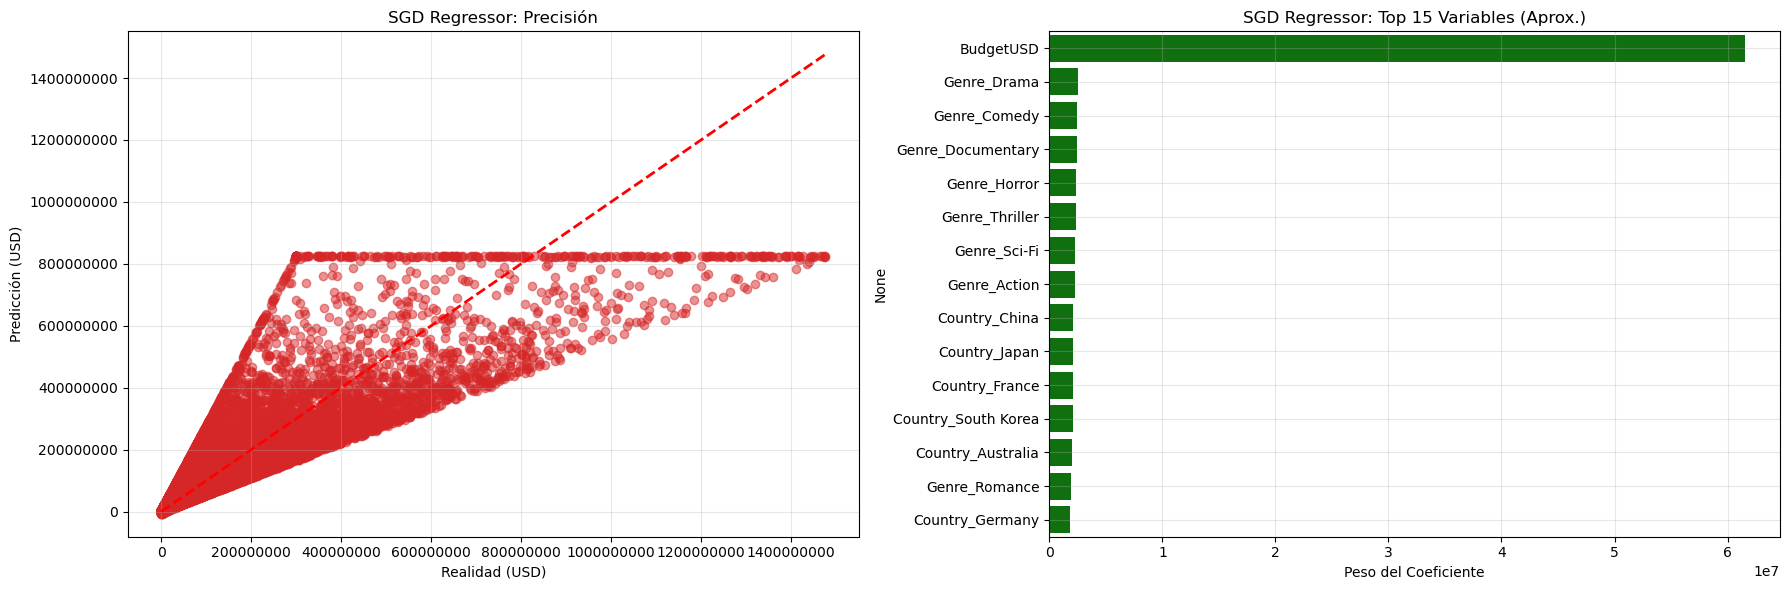


=== EVALUATION REPORT: SGD Regressor ===
R2 Score (Train): 0.8010
R2 Score (Test):  0.8036
 STATUS: Healthy model (Good generalization).


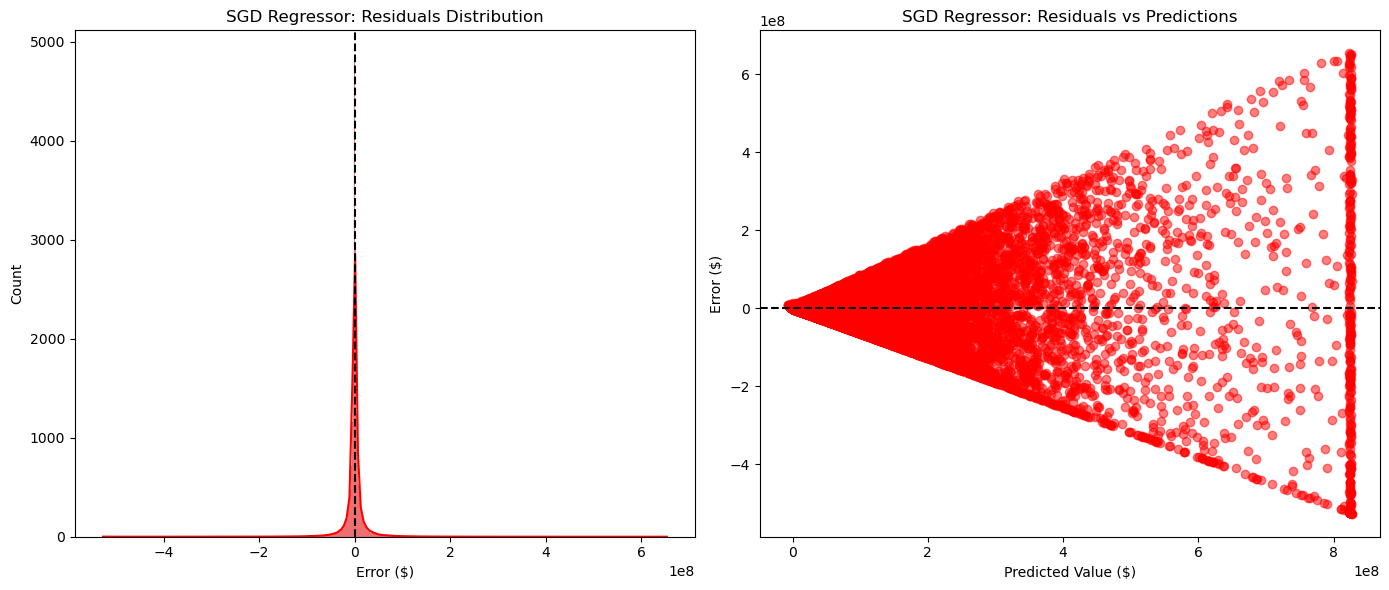


=== PERFORMANCE METRICS ===
R² Score:       0.8036
Adjusted R²:    0.8039
RMSE:           $31,323,878.57
MAE:            $10,991,272.66
MAPE:           73.29%

=== COEFFICIENT INTERPRETATION ===

TOP 5 POSITIVE IMPACT (Increase Box Office):
  • BudgetUSD: +$61,561,289.91
  • Genre_Drama: +$2,566,320.51
  • Genre_Comedy: +$2,481,244.92
  • Genre_Documentary: +$2,413,658.78
  • Genre_Horror: +$2,390,444.25

TOP 5 NEGATIVE IMPACT (Decrease Box Office):
  • ReleaseDate_Day: $-712,600.46
  • IMDbRating: $-191,423.18
  • NumVotesIMDb: $-180,668.32
  • NumVotesRT: $-107,530.55
  • ReleaseDate_Year: $255,930.86

NOTE: Coefficients show the change in Box Office (in $) for a
1-unit increase in the feature (after scaling).


In [18]:
print("\n--- 5. SGD REGRESSOR ---")

# A. Initialize SGD
sgd_model = SGDRegressor(
    max_iter=1000, 
    tol=1e-3, 
    penalty='elasticnet', 
    random_state=42
)

# B. Train
sgd_model.fit(X_train_numerical, y_train) 

# C. Predict
y_pred_sgd = sgd_model.predict(X_test_numerical)  

# D. Evaluate
r2_sgd = r2_score(y_test, y_pred_sgd)
rmse_sgd = np.sqrt(mean_squared_error(y_test, y_pred_sgd))

print(f"R2 Score: {r2_sgd:.4f}")
print(f"RMSE:     ${rmse_sgd:,.2f}")

#VISUALIZATION
model = sgd_model
name = "SGD Regressor"

plt.figure(figsize=(18, 6))

# Graph1: Reality vs Prediction
plt.subplot(1, 2, 1)
plt.scatter(y_test, y_pred_sgd, alpha=0.5, color='tab:red') 
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.xlabel('Realidad (USD)')
plt.ylabel('Predicción (USD)')
plt.title(f'{name}: Precisión')
plt.grid(True, alpha=0.3)
plt.ticklabel_format(style='plain', axis='both')

# Graph2: Top Coefficients
plt.subplot(1, 2, 2)
coefs = pd.Series(model.coef_, index=X_test_numerical.columns) 
top_coefs = coefs.abs().sort_values(ascending=False).head(15)
top_coefs_original = coefs[top_coefs.index]
colors = ['green' if x > 0 else 'red' for x in top_coefs_original]

sns.barplot(x=top_coefs_original, y=top_coefs_original.index, palette=colors)
plt.title(f'{name}: Top 15 Variables (Aprox.)')
plt.xlabel('Peso del Coeficiente')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

#EVALUATION
# --- EVALUATION: SGD REGRESSOR ---
model_name = "SGD Regressor"
current_model = sgd_model

print(f"\n=== EVALUATION REPORT: {model_name} ===")

# 1. OVERFITTING CHECK
y_train_pred = current_model.predict(X_train_numerical) 

r2_train = r2_score(y_train, y_train_pred)
r2_test = r2_score(y_test, y_pred_sgd)  

print(f"R2 Score (Train): {r2_train:.4f}")
print(f"R2 Score (Test):  {r2_test:.4f}")

diff = r2_train - r2_test
if diff > 0.10:
    print(f" WARNING: High Overfitting detected (Difference: {diff:.2f}).")
else:
    print(f" STATUS: Healthy model (Good generalization).")

# 2. RESIDUALS ANALYSIS
residuals = y_test - y_pred_sgd 

plt.figure(figsize=(14, 6))

# Plot A: Distribution
plt.subplot(1, 2, 1)
sns.histplot(residuals, kde=True, color='red')
plt.axvline(x=0, color='black', linestyle='--')
plt.title(f'{model_name}: Residuals Distribution')
plt.xlabel('Error ($)')

# Plot B: Residuals vs Predicted
plt.subplot(1, 2, 2)
plt.scatter(y_pred_sgd, residuals, alpha=0.5, color='red') 
plt.axhline(y=0, color='black', linestyle='--')
plt.title(f'{model_name}: Residuals vs Predictions')
plt.xlabel('Predicted Value ($)')
plt.ylabel('Error ($)')

plt.tight_layout()
plt.show()

# Additional metrics
mae_sgd = mean_absolute_error(y_test, y_pred_sgd)
mape_sgd = np.mean(np.abs((y_test - y_pred_sgd) / y_test)) * 100

# Adjusted R²
n_samples = X_test_numerical.shape[0]
n_features = X_test_numerical.shape[1]
adj_r2_sgd = 1 - (1 - r2_ols) * (n_samples - 1) / (n_samples - n_features - 1)

print(f"\n=== PERFORMANCE METRICS ===")
print(f"R² Score:       {r2_sgd:.4f}")
print(f"Adjusted R²:    {adj_r2_sgd:.4f}")
print(f"RMSE:           ${rmse_sgd:,.2f}")
print(f"MAE:            ${mae_sgd:,.2f}")
print(f"MAPE:           {mape_sgd:.2f}%")


print("\n=== COEFFICIENT INTERPRETATION ===")

# Get coefficients
coefs = pd.Series(sgd_model.coef_, index=X_train_numerical.columns)

# Top 5 positive impact
top_positive = coefs.nlargest(5)
print("\nTOP 5 POSITIVE IMPACT (Increase Box Office):")
for feature, coef in top_positive.items():
    print(f"  • {feature}: +${coef:,.2f}")

# Top 5 negative impact
top_negative = coefs.nsmallest(5)
print("\nTOP 5 NEGATIVE IMPACT (Decrease Box Office):")
for feature, coef in top_negative.items():
    print(f"  • {feature}: ${coef:,.2f}")

# Interpretation note
print("\nNOTE: Coefficients show the change in Box Office (in $) for a")
print("1-unit increase in the feature (after scaling).")

FINAL MODEL COMPARISONS


           FINAL COMPARISON: LINEAR REGRESSION MODELS

     Model  R² (Test)         RMSE
       OLS   0.803929 3.129874e+07
     Ridge   0.803929 3.129880e+07
     Lasso   0.803926 3.129901e+07
       SGD   0.803614 3.132388e+07
ElasticNet   0.002523 7.059470e+07


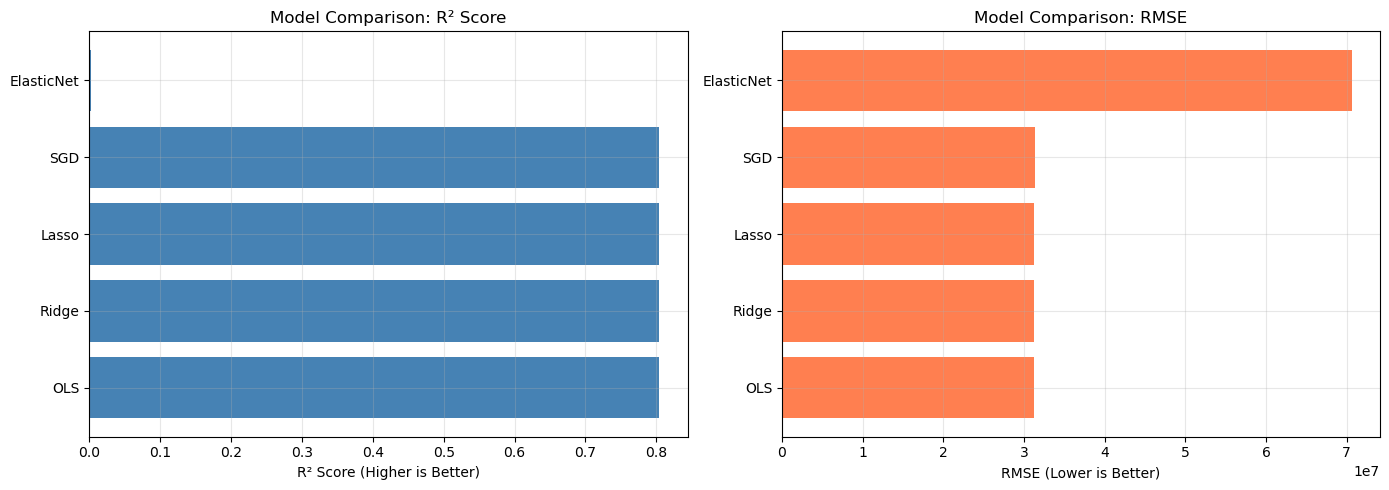


🏆 WINNER: The best model is OLS with R² = 0.8039


In [ ]:
# ============================================================
# FINAL COMPARISON: ALL LINEAR REGRESSION MODELS
# ============================================================

print("\n" + "="*70)
print("           FINAL COMPARISON: LINEAR REGRESSION MODELS")
print("="*70)

# Calculate metrics for all models
models_data = {
    'OLS': (ols_model, X_train_numerical, X_test_numerical),
    'Ridge': (ridge_model, X_train_numerical, X_test_numerical),
    'Lasso': (lasso_model, X_train_numerical, X_test_numerical),
    'ElasticNet': (elastic_model, X_train_numerical, X_test_numerical),
    'SGD': (sgd_model, X_train_numerical, X_test_numerical)
}

results_list = []

for name, (model, X_train, X_test) in models_data.items():
    y_pred = model.predict(X_test)
    r2 = r2_score(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    
    results_list.append({
        'Model': name,
        'R² (Test)': r2,
        'RMSE': rmse
    })

results = pd.DataFrame(results_list)
results = results.sort_values('R² (Test)', ascending=False)
print("\n" + results.to_string(index=False))

# Visualization
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Graph 1: R² Score
axes[0].barh(results['Model'], results['R² (Test)'], color='steelblue')
axes[0].set_xlabel('R² Score (Higher is Better)')
axes[0].set_title('Model Comparison: R² Score')
axes[0].grid(True, alpha=0.3)

# Graph 2: RMSE
axes[1].barh(results['Model'], results['RMSE'], color='coral')
axes[1].set_xlabel('RMSE (Lower is Better)')
axes[1].set_title('Model Comparison: RMSE')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("\n" + "="*70)
print(f"🏆 WINNER: The best model is {results.iloc[0]['Model']} with R² = {results.iloc[0]['R² (Test)']:.4f}")
print("="*70)

POLYNOMIAL REGRESSION(We will predict the Global_BoxOfficeUSD based on the BudgetUSD)

In [4]:
# --- POLYNOMIAL REGRESSION DATA PREPARATION ---

# Para polynomial regression, usamos solo 'BudgetUSD' para poder visualizar la curva
X_poly_train = X_train_numerical[['BudgetUSD']]
X_poly_test = X_test_numerical[['BudgetUSD']]

print(f"Predictor: BudgetUSD")
print(f"Target: Global_BoxOfficeUSD")
print(f"Train samples: {X_poly_train.shape[0]}")
print(f"Test samples: {X_poly_test.shape[0]}")

Predictor: BudgetUSD
Target: Global_BoxOfficeUSD
Train samples: 799999
Test samples: 200000


--- STARTING POLYNOMIAL REGRESSION (DEGREE 10) ---
Model trained successfully.

=== PERFORMANCE METRICS ===
R2 Score: 0.8039
RMSE:     $31,298,231.52
Model Coefficients: [ 6.28586177e+07 -2.64930243e+04 -2.58317055e+06  2.80538810e+06
 -1.32983946e+06  3.44175339e+05 -5.17314747e+04  4.48735807e+03
 -2.07737261e+02  3.96493569e+00]


c:\Users\asier.vinos\AppData\Local\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
c:\Users\asier.vinos\AppData\Local\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but PolynomialFeatures was fitted with feature names
  warnings.warn(


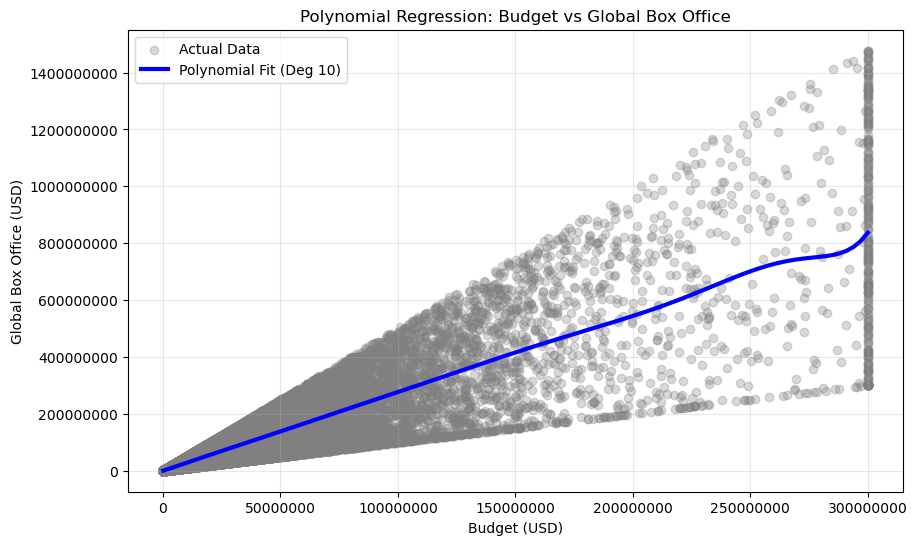


=== EVALUATION REPORT ===
R2 (Train): 0.8014
R2 (Test):  0.8039
 STATUS: Healthy model (Good generalization).


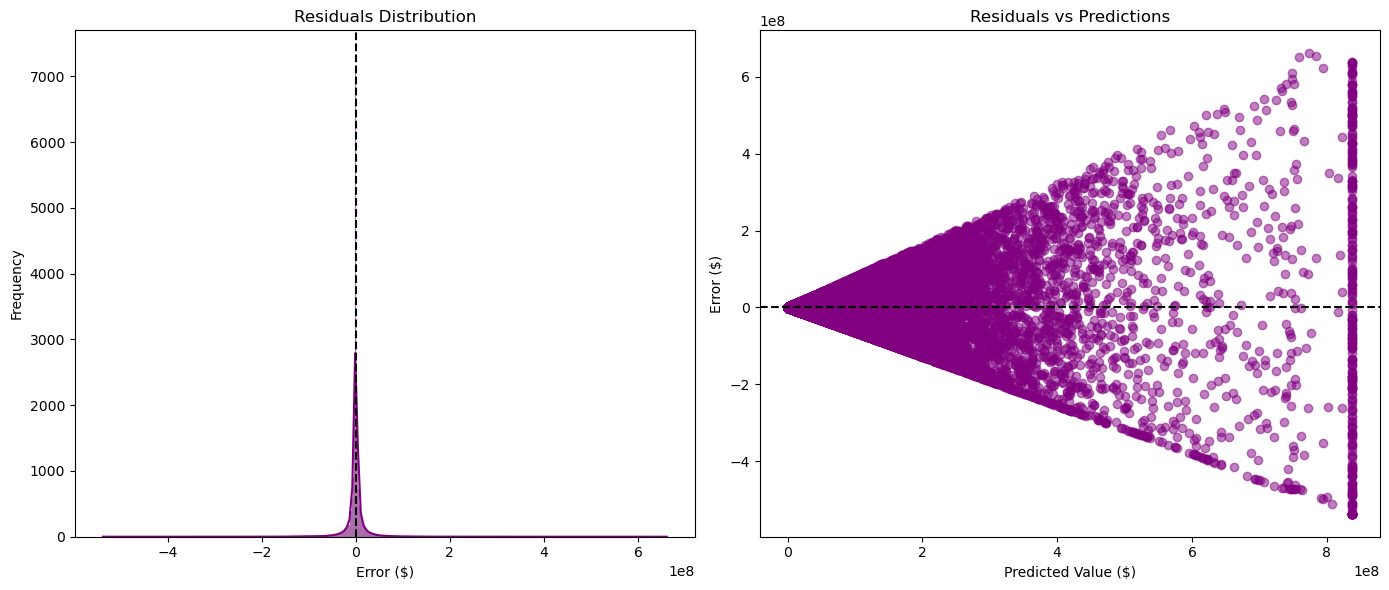

In [5]:
# --- CONFIGURATION ---
poly_degree = 10  # Degree 2 is usually sufficient for this type of data

print(f"--- STARTING POLYNOMIAL REGRESSION (DEGREE {poly_degree}) ---")

# --- 1. MODEL TRAINING ---
# Create a Pipeline: 
# 1. Generate Polynomial Features (x -> x, x^2)
# 2. Fit Linear Regression on those features
poly_model = Pipeline([
    ('poly', PolynomialFeatures(degree=poly_degree, include_bias=False)),
    ('linear', LinearRegression())
])

# Train the model on the scaled training data
poly_model.fit(X_poly_train, y_train) 
print("Model trained successfully.")

# --- 2. PREDICTION & BASIC METRICS ---
# Predict on the test set
y_pred_poly = poly_model.predict(X_poly_test) 

# Calculate standard metrics
r2 = r2_score(y_test, y_pred_poly)
rmse = np.sqrt(mean_squared_error(y_test, y_pred_poly))

print(f"\n=== PERFORMANCE METRICS ===")
print(f"R2 Score: {r2:.4f}")
print(f"RMSE:     ${rmse:,.2f}")

# Check linear coefficients to see if the curve is significant
linear_part = poly_model.named_steps['linear']
print(f"Model Coefficients: {linear_part.coef_}")


# --- 3. VISUALIZATION OF THE CURVE ---
plt.figure(figsize=(10, 6))

# A. Scatter plot of Real Test Data
# BudgetUSD ya está escalado, pero para visualización necesitamos crear un scaler
# Solo para poder hacer inverse_transform
scaler_viz = StandardScaler()
scaler_viz.fit(X_train[['BudgetUSD']])  # Fit con datos originales sin escalar

X_test_dollars = scaler_viz.inverse_transform(X_poly_test) 
plt.scatter(X_test_dollars, y_test, color='gray', alpha=0.3, label='Actual Data')

# B. Plotting the Smooth Curve
# Generate a range of values, scale them, and predict to get a smooth line
X_range = np.linspace(X_test_dollars.min(), X_test_dollars.max(), 100).reshape(-1, 1)
X_range_scaled = scaler_viz.transform(X_range) 
y_range_pred = poly_model.predict(X_range_scaled)

plt.plot(X_range, y_range_pred, color='blue', linewidth=3, label=f'Polynomial Fit (Deg {poly_degree})')

plt.title(f'Polynomial Regression: Budget vs Global Box Office')
plt.xlabel('Budget (USD)')
plt.ylabel('Global Box Office (USD)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.ticklabel_format(style='plain', axis='both')
plt.show()


# --- 4. DEEP EVALUATION (OVERFITTING & RESIDUALS) ---
print(f"\n=== EVALUATION REPORT ===")

# A. OVERFITTING CHECK
# Compare performance on Train data vs. Test data
y_train_pred = poly_model.predict(X_poly_train)
r2_train = r2_score(y_train, y_train_pred)
r2_test_final = r2_score(y_test, y_pred_poly)

print(f"R2 (Train): {r2_train:.4f}")
print(f"R2 (Test):  {r2_test_final:.4f}")

diff = r2_train - r2_test_final
if diff > 0.10:
    print(f" WARNING: High Overfitting detected (Difference: {diff:.2f}).")
    print("The curve is wiggling too much to fit the training points.")
elif diff < -0.05:
    print(f" Suspicious: Test score is significantly better than Train score.")
else:
    print(f" STATUS: Healthy model (Good generalization).")

# B. RESIDUALS ANALYSIS
# Calculate errors
residuals = y_test - y_pred_poly

plt.figure(figsize=(14, 6))

# Plot B1: Residuals Distribution (Histogram)
plt.subplot(1, 2, 1)
sns.histplot(residuals, kde=True, color='purple')
plt.axvline(x=0, color='black', linestyle='--')
plt.title('Residuals Distribution')
plt.xlabel('Error ($)')
plt.ylabel('Frequency')

# Plot B2: Residuals vs Predicted
plt.subplot(1, 2, 2)
plt.scatter(y_pred_poly, residuals, alpha=0.5, color='purple')
plt.axhline(y=0, color='black', linestyle='--')
plt.title('Residuals vs Predictions')
plt.xlabel('Predicted Value ($)')
plt.ylabel('Error ($)')

plt.tight_layout()
plt.show()

POLYNOMIAL DEGREE EXPERIMENTATION


      POLYNOMIAL REGRESSION: DEGREE COMPARISON

Training Polynomial Regression with degree=2...

Training Polynomial Regression with degree=3...

Training Polynomial Regression with degree=4...

Training Polynomial Regression with degree=5...

Training Polynomial Regression with degree=10...

 Degree  R² Train  R² Test         RMSE  Overfitting (Δ)
      2  0.801303 0.803929 3.129880e+07        -0.002626
      3  0.801311 0.803875 3.130306e+07        -0.002564
      4  0.801316 0.803864 3.130396e+07        -0.002548
      5  0.801318 0.803876 3.130303e+07        -0.002558
     10  0.801379 0.803936 3.129823e+07        -0.002557


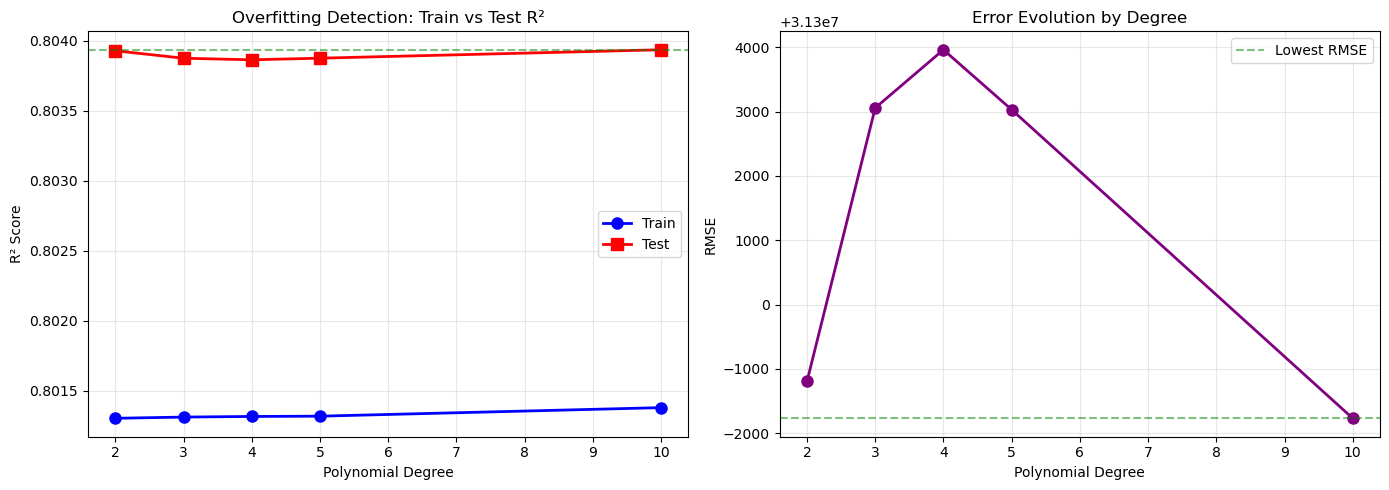


ANALYSIS:

✓ BEST DEGREE: 10
  - R² Test: 0.8039
  - Overfitting: -0.0026

🏆 RECOMMENDATION: Use Polynomial Degree = 10


In [21]:
# ============================================================
# POLYNOMIAL DEGREE EXPERIMENTATION
# ============================================================

print("\n" + "="*70)
print("      POLYNOMIAL REGRESSION: DEGREE COMPARISON")
print("="*70)

degrees = [2, 3, 4, 5, 10]
poly_results = []

for degree in degrees:
    print(f"\nTraining Polynomial Regression with degree={degree}...")
    
    # Train model
    poly_model_temp = Pipeline([
        ('poly', PolynomialFeatures(degree=degree, include_bias=False)),
        ('linear', LinearRegression())
    ])
    
    poly_model_temp.fit(X_poly_train, y_train)
    
    # Predict
    y_train_pred = poly_model_temp.predict(X_poly_train)
    y_test_pred = poly_model_temp.predict(X_poly_test)
    
    # Metrics
    r2_train = r2_score(y_train, y_train_pred)
    r2_test = r2_score(y_test, y_test_pred)
    rmse_test = np.sqrt(mean_squared_error(y_test, y_test_pred))
    
    poly_results.append({
        'Degree': degree,
        'R² Train': r2_train,
        'R² Test': r2_test,
        'RMSE': rmse_test,
        'Overfitting (Δ)': r2_train - r2_test
    })

# Results table
poly_df = pd.DataFrame(poly_results)
print("\n" + poly_df.to_string(index=False))

# Visualization
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Graph 1: R² Train vs Test (Overfitting Detection)
axes[0].plot(poly_df['Degree'], poly_df['R² Train'], 'o-', 
             label='Train', linewidth=2, markersize=8, color='blue')
axes[0].plot(poly_df['Degree'], poly_df['R² Test'], 's-', 
             label='Test', linewidth=2, markersize=8, color='red')
axes[0].set_xlabel('Polynomial Degree')
axes[0].set_ylabel('R² Score')
axes[0].set_title('Overfitting Detection: Train vs Test R²')
axes[0].legend()
axes[0].grid(True, alpha=0.3)
axes[0].axhline(y=poly_df['R² Test'].max(), color='green', 
                linestyle='--', alpha=0.5, label='Best Test R²')

# Graph 2: RMSE Evolution
axes[1].plot(poly_df['Degree'], poly_df['RMSE'], 'o-', 
             color='purple', linewidth=2, markersize=8)
axes[1].set_xlabel('Polynomial Degree')
axes[1].set_ylabel('RMSE')
axes[1].set_title('Error Evolution by Degree')
axes[1].grid(True, alpha=0.3)
axes[1].axhline(y=poly_df['RMSE'].min(), color='green', 
                linestyle='--', alpha=0.5, label='Lowest RMSE')
axes[1].legend()

plt.tight_layout()
plt.show()

# Analysis and recommendation
print("\n" + "="*70)
print("ANALYSIS:")
print("="*70)

best_idx = poly_df['R² Test'].idxmax()
best_degree = int(poly_df.loc[best_idx, 'Degree'])
best_r2 = poly_df.loc[best_idx, 'R² Test']
best_overfitting = poly_df.loc[best_idx, 'Overfitting (Δ)']

print(f"\n✓ BEST DEGREE: {best_degree}")
print(f"  - R² Test: {best_r2:.4f}")
print(f"  - Overfitting: {best_overfitting:.4f}")

# Check for overfitting in high degrees
high_degree_row = poly_df[poly_df['Degree'] == 10].iloc[0]
if high_degree_row['Overfitting (Δ)'] > 0.10:
    print(f"\n⚠ WARNING: Degree 10 shows severe overfitting!")
    print(f"  - Train R²: {high_degree_row['R² Train']:.4f}")
    print(f"  - Test R²:  {high_degree_row['R² Test']:.4f}")
    print(f"  - Difference: {high_degree_row['Overfitting (Δ)']:.4f}")
    print("  → The model memorizes training data but fails to generalize.")

print("\n" + "="*70)
print(f"🏆 RECOMMENDATION: Use Polynomial Degree = {best_degree}")
print("="*70)

RANSAC

In [26]:
ransac = RANSACRegressor(
  LinearRegression(),
  max_trials=500, 
  min_samples=0.5,
  residual_threshold=None,
  random_state=123)

ransac.fit(X_train_numerical, y_train)

,estimator,LinearRegression()
,min_samples,0.5
,residual_threshold,None
,is_data_valid,None
,is_model_valid,None
,max_trials,500
,max_skips,inf
,stop_n_inliers,inf
,stop_score,inf
,stop_probability,0.99
,loss,'absolute_error'


In [27]:
y_pred = ransac.predict(X_test_numerical)

RANSAC - Model Evaluation

In [28]:
# Mean Absolute Error
mae = mean_absolute_error(y_test, y_pred)
print(f"MAE: {mae:.2f}")

# R²
r2 = r2_score(y_test, y_pred)
print(f"R²: {r2:.4f}")

# Adjusted R²  
n = X_test_numerical.shape[0]     
p = X_test_numerical.shape[1]     
adjusted_r2 = 1 - (1 - r2) * (n - 1) / (n - p - 1)
print(f"Adjusted R²: {adjusted_r2:.4f}")


#  Mean Squared Log Error
y_pred_positive = np.maximum(y_pred, 1) #we correct negative values that make msle not work
msle = mean_squared_log_error(y_test, y_pred_positive)
print(f"MSLE: {msle:.6f}")

# Root Mean Squared Error
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print(f"RMSE: {rmse:.2f}")


MAE: 10836914.43
R²: 0.8039
Adjusted R²: 0.8039
MSLE: 0.284673
RMSE: 31298233.62


In [29]:
# analyze inliers and outliers
inlier_mask = ransac.inlier_mask_
outlier_mask = ~inlier_mask

n_inliers = np.sum(inlier_mask)
n_outliers = np.sum(outlier_mask)

print(f"\nRANSAC analysis:")
print(f"Inliers detected: {n_inliers} ({n_inliers/len(y_train)*100:.1f}%)")
print(f"Outliers detected: {n_outliers} ({n_outliers/len(y_train)*100:.1f}%)")


RANSAC analysis:
Inliers detected: 549458 (68.7%)
Outliers detected: 250541 (31.3%)


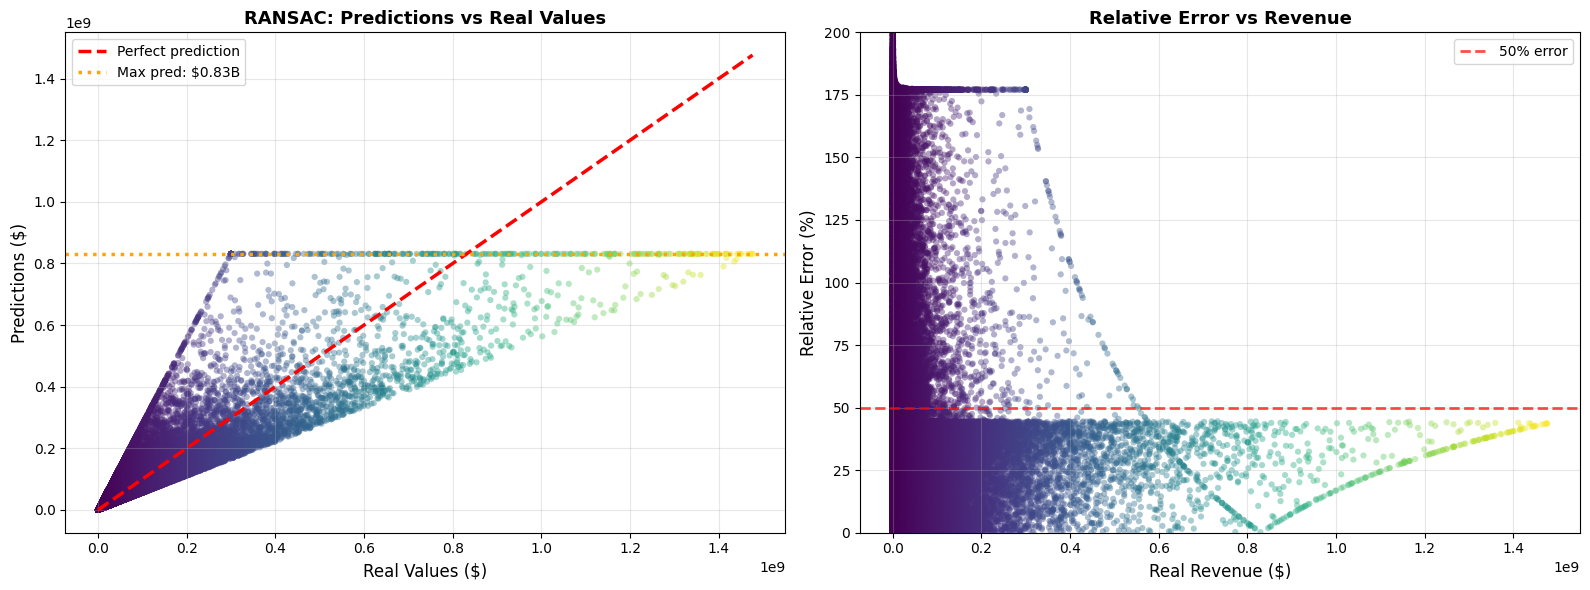

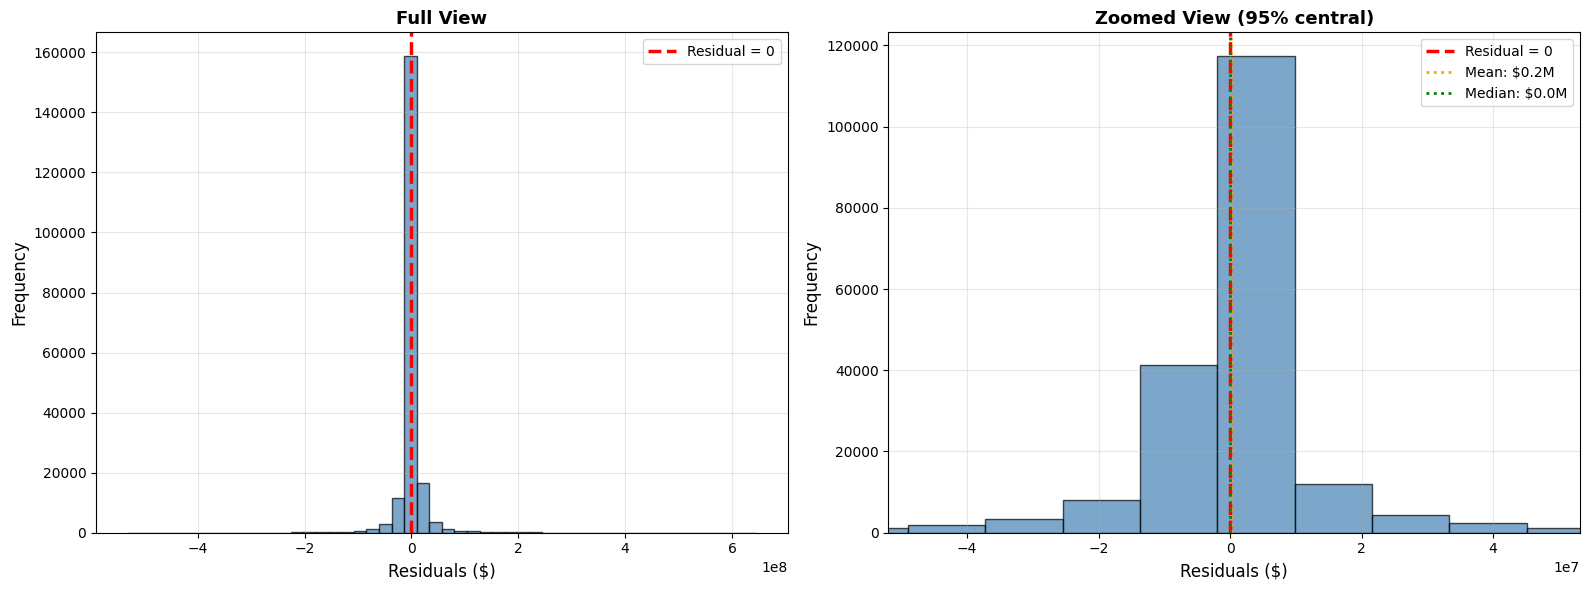


Residual Stats:
   Mean:     $159,894
   Median:   $11,942
   Skewness: 0.607 → Systematical subestimation


In [33]:
# Visualization
# Predictions vs real values
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Left side panel: full scatter plot
axes[0].scatter(y_test, y_pred, alpha=0.4, s=20, c=y_test, cmap='viridis', edgecolors='none')
axes[0].plot([y_test.min(), y_test.max()], 
             [y_test.min(), y_test.max()], 
             'r--', lw=2.5, label='Perfect prediction')
max_pred = y_pred.max()
axes[0].axhline(y=max_pred, color='orange', linestyle=':', 
                linewidth=2.5, label=f'Max pred: ${max_pred/1e9:.2f}B')
axes[0].set_xlabel('Real Values ($)', fontsize=12)
axes[0].set_ylabel('Predictions ($)', fontsize=12)
axes[0].set_title('RANSAC: Predictions vs Real Values', fontsize=13, fontweight='bold')
axes[0].legend(fontsize=10)
axes[0].grid(True, alpha=0.3)

# Right side panel: relative error
relative_error = np.abs((y_test - y_pred) / y_test) * 100
mask = relative_error < 200
axes[1].scatter(y_test[mask], relative_error[mask], alpha=0.4, s=20, 
                c=y_test[mask], cmap='viridis', edgecolors='none')
axes[1].axhline(y=50, color='red', linestyle='--', linewidth=2, 
                alpha=0.7, label='50% error')
axes[1].set_xlabel('Real Revenue ($)', fontsize=12)
axes[1].set_ylabel('Relative Error (%)', fontsize=12)
axes[1].set_title('Relative Error vs Revenue', fontsize=13, fontweight='bold')
axes[1].legend(fontsize=10)
axes[1].grid(True, alpha=0.3)
axes[1].set_ylim(0, 200)

plt.tight_layout()
plt.show()

# Residual distribution
residuals = y_test - y_pred
p2_5 = np.percentile(residuals, 2.5)
p97_5 = np.percentile(residuals, 97.5)
mean_res = np.mean(residuals)
median_res = np.median(residuals)

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Left side panel: full view
axes[0].hist(residuals, bins=50, edgecolor='black', alpha=0.7, color='steelblue')
axes[0].axvline(x=0, color='r', linestyle='--', linewidth=2.5, label='Residual = 0')
axes[0].set_xlabel('Residuals ($)', fontsize=12)
axes[0].set_ylabel('Frequency', fontsize=12)
axes[0].set_title('Full View', fontsize=13, fontweight='bold')
axes[0].legend(fontsize=10)
axes[0].grid(True, alpha=0.3)

# Right side panel: zoomed in
axes[1].hist(residuals, bins=100, edgecolor='black', alpha=0.7, color='steelblue')
axes[1].axvline(x=0, color='r', linestyle='--', linewidth=2.5, label='Residual = 0')
axes[1].axvline(x=mean_res, color='orange', linestyle=':', 
                linewidth=2, label=f'Mean: ${mean_res/1e6:.1f}M')
axes[1].axvline(x=median_res, color='green', linestyle=':', 
                linewidth=2, label=f'Median: ${median_res/1e6:.1f}M')
axes[1].set_xlim(p2_5 * 1.2, p97_5 * 1.2)
axes[1].set_xlabel('Residuals ($)', fontsize=12)
axes[1].set_ylabel('Frequency', fontsize=12)
axes[1].set_title(f'Zoomed View (95% central)', fontsize=13, fontweight='bold')
axes[1].legend(fontsize=10)
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# EStatistics
skewness = np.mean((residuals - mean_res)**3) / np.std(residuals)**3
print(f"\nResidual Stats:")
print(f"   Mean:     ${mean_res:,.0f}")
print(f"   Median:   ${median_res:,.0f}")
print(f"   Skewness: {skewness:.3f}", "→ Systematical subestimation" if skewness > 0.5 else "")

Theil-Sen

In [4]:
from sklearn.linear_model import TheilSenRegressor

# Crear el modelo
theilsen_model = TheilSenRegressor(random_state=42)

# Entrenar
theilsen_model.fit(X_train_numerical, y_train)

# Predecir
y_pred_train = theilsen_model.predict(X_train_numerical)
y_pred_test = theilsen_model.predict(X_test_numerical)

# Evaluar con las 3 métricas principales para regresión
print("=== TRAIN ===")
print("R² Train:", r2_score(y_train, y_pred_train))
print("MAE Train:", mean_absolute_error(y_train, y_pred_train))
print("RMSE Train:", np.sqrt(mean_squared_error(y_train, y_pred_train)))

print("\n=== TEST ===")
print("R² Test:", r2_score(y_test, y_pred_test))
print("MAE Test:", mean_absolute_error(y_test, y_pred_test))
print("RMSE Test:", np.sqrt(mean_squared_error(y_test, y_pred_test)))


=== TRAIN ===
R² Train: 0.8010459655217057
MAE Train: 10881615.916655585
RMSE Train: 30890465.592319172

=== TEST ===
R² Test: 0.803648668617797
MAE Test: 10978182.244639417
RMSE Test: 31321135.74458096


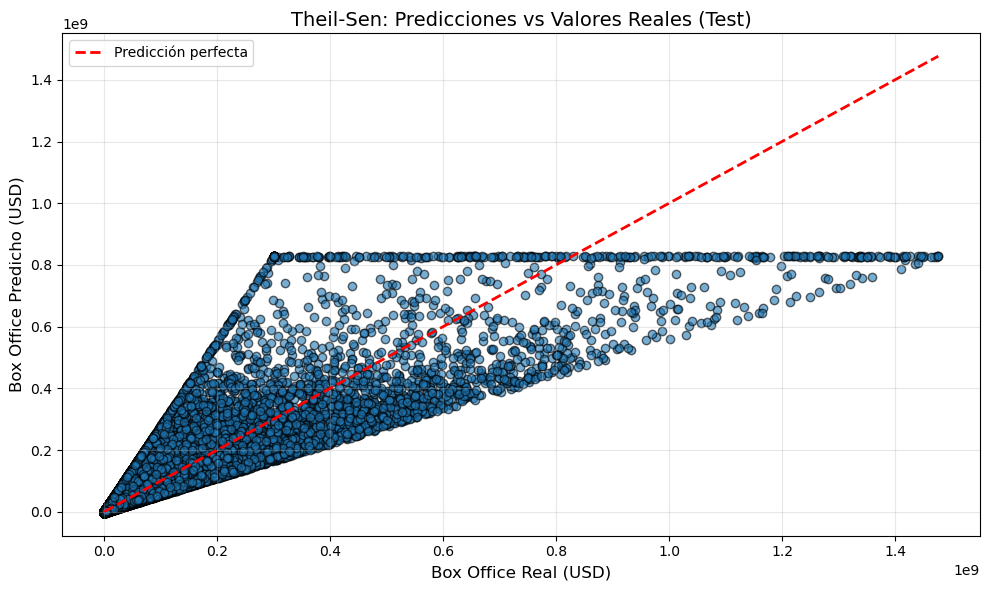

In [5]:
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred_test, alpha=0.6, edgecolors='k')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 
         'r--', lw=2, label='Predicción perfecta')
plt.xlabel('Box Office Real (USD)', fontsize=12)
plt.ylabel('Box Office Predicho (USD)', fontsize=12)
plt.title('Theil-Sen: Predicciones vs Valores Reales (Test)', fontsize=14)
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()


Model Evaluation

HUBBER

Computed δ (Huber threshold): 8851259.564849999

----- Huber Regression Evaluation -----
MAE: 10843129.50846523
MSE: 982645050756396.4
RMSE: 31347169.740766015
R²: 0.8033221201611105


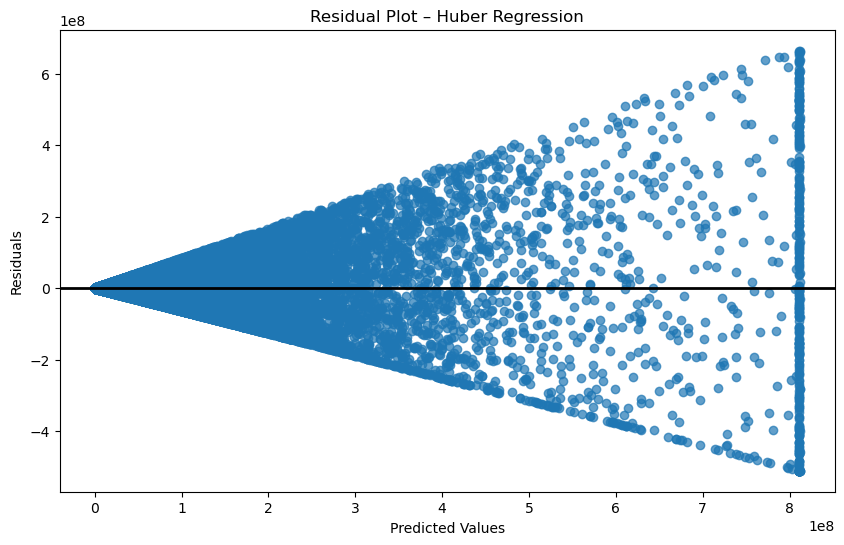

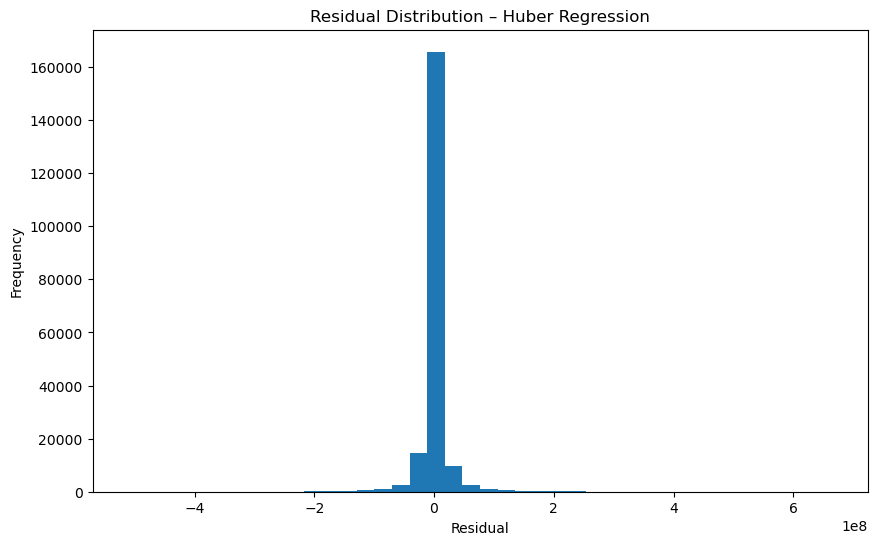


Huber Model Coefficients:
BudgetUSD: 60600045.13684148
US_BoxOfficeUSD: 6138.346445032975
Opening_Day_SalesUSD: -7621.537262069509
One_Week_SalesUSD: 4547.536272614195
IMDbRating: 1699.193944133858
RottenTomatoesScore: -6771.622628278568
NumVotesIMDb: 2575.805135131188
NumVotesRT: 1495.4081302042564

Huber Intercept: 26594874.57536944


In [ ]:
###############################################
# Huber Regression – Preprocessing + Modeling #
###############################################

# Select numerical features for regression (same structure as RANSAC)
numerical_features = [
    'BudgetUSD', 'US_BoxOfficeUSD', 'Opening_Day_SalesUSD',
    'One_Week_SalesUSD', 'IMDbRating', 'RottenTomatoesScore',
    'NumVotesIMDb', 'NumVotesRT'
]


X = df.drop(columns=['Global_BoxOfficeUSD'])  #SAME AS IMPORTS
y = df['Global_BoxOfficeUSD'] #SAME AS IMPORTS

X_train_input = X_train_numerical.copy()
X_test_input = X_test_numerical.copy()

###############################################
# 1. Train–Test Split (BEFORE transformations)
###############################################
#from sklearn.model_selection import train_test_split

###############################################
# 2. Preprocessing (Scaling AFTER the split)
###############################################
#from sklearn.preprocessing import StandardScaler

#scaler = StandardScaler()

# Fit scaler ONLY on training data
#X_train_scaled = scaler.fit_transform(X_train)
#X_test_scaled = scaler.transform(X_test)

###############################################
# 3. Compute δ using MAD (Median Absolute Deviation)
###############################################

import numpy as np

# Step 1: Initialize coefficients to zero → prediction = 0
baseline_pred = np.zeros_like(y_train)

# Step 2 & 3: Compute residuals
residuals = y_train - baseline_pred

# Step 4: MAD
mad = np.median(np.abs(residuals - np.median(residuals)))

# δ calculation
delta_value = 1.345 * mad
print("HUBER REGRESSION - COMPREHENSIVE EVALUATION")
print("Computed δ (Huber threshold):", delta_value)
print("HYPERPARAMETER TUNING")

param_grid = {
    'epsilon': [1.1, 1.345, 1.5, 2.0],
    'alpha': [0.00001, 0.0001, 0.001, 0.01]
}

###############################################
# 4. Train Huber Regressor
###############################################
from sklearn.linear_model import HuberRegressor

huber_grid = GridSearchCV(
    HuberRegressor(max_iter=1000),
    param_grid,
    cv=5,
    scoring='r2',
    n_jobs=-1
)

huber_grid.fit(X_train_input, y_train)

print(f"\nBest parameters: {huber_grid.best_params_}")
print(f"Best CV R² score: {huber_grid.best_score_:.4f}")

# Use best model
best_huber = huber_grid.best_estimator_
###############################################

print("CROSS-VALIDATION ANALYSIS (5-Fold)")

cv_r2 = cross_val_score(best_huber, X_train_numerical, y_train, cv=5, scoring='r2')
cv_mae = cross_val_score(best_huber, X_train_numerical, y_train, cv=5, scoring='neg_mean_absolute_error')
cv_rmse = cross_val_score(best_huber, X_train_numerical, y_train, cv=5, scoring='neg_root_mean_squared_error')

print(f"\nR² scores: {cv_r2}")
print(f"Mean CV R²: {cv_r2.mean():.4f} (± {cv_r2.std() * 2:.4f})")
print(f"\nMAE scores: {-cv_mae}")
print(f"Mean CV MAE: {-cv_mae.mean():,.2f} (± {cv_mae.std() * 2:,.2f})")
print(f"\nRMSE scores: {-cv_rmse}")
print(f"Mean CV RMSE: {-cv_rmse.mean():,.2f} (± {cv_rmse.std() * 2:,.2f})")
# 5. Predictions
###############################################
best_huber.fit(X_train_numerical, y_train)
y_pred_train = best_huber.predict(X_train_numerical)
y_pred_test = best_huber.predict(X_test_numerical)
###############################################
print("\nCOMPARISON WITH OTHER MODELS")
models = {
    'Huber (Tuned)': best_huber,
    'Linear Regression': LinearRegression(),
    'Ridge (α=1.0)': Ridge(alpha=1.0),
    'Lasso (α=0.01)': Lasso(alpha=0.01, max_iter=5000)
}

comparison_results = []

for name, model in models.items():
    if name != 'Huber (Tuned)':  # Huber already fitted
        model.fit(X_train_numerical, y_train)
    
    y_pred = model.predict(X_test_numerical)
    
    mae = mean_absolute_error(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    r2 = r2_score(y_test, y_pred)
    
    comparison_results.append({
        'Model': name,
        'MAE': mae,
        'RMSE': rmse,
        'R²': r2
    })

comparison_df = pd.DataFrame(comparison_results)
print("\n" + comparison_df.to_string(index=False))


print("HUBER REGRESSION - DETAILED EVALUATION")
# 6. Model Evaluation
###############################################
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

mae_test = mean_absolute_error(y_test, y_pred)
mse_test = mean_squared_error(y_test, y_pred)
rmse_test = np.sqrt(mse_test)
r2_test = r2_score(y_test, y_pred)

mae_train = mean_absolute_error(y_train, y_pred_train)
r2_train = r2_score(y_train, y_pred_train)

print(f"\nTest Set Performance:")
print(f"  MAE:  ${mae_test:,.2f}")
print(f"  MSE:  {mse_test:,.2f}")
print(f"  RMSE: ${rmse_test:,.2f}")
print(f"  R²:   {r2_test:.4f}")

print(f"\nTraining Set Performance:")
print(f"  MAE:  ${mae_train:,.2f}")
print(f"  R²:   {r2_train:.4f}")

# Contextualize errors
mean_boxoffice = y_test.mean()
std_boxoffice = y_test.std()
mae_percentage = (mae_test / mean_boxoffice) * 100
rmse_percentage = (rmse_test / mean_boxoffice) * 100

print(f"\nTarget Variable Statistics:")
print(f"  Mean Box Office: ${mean_boxoffice:,.2f}")
print(f"  Std Box Office:  ${std_boxoffice:,.2f}")
print(f"\nError Context:")
print(f"  MAE is {mae_percentage:.1f}% of mean box office")
print(f"  RMSE is {rmse_percentage:.1f}% of mean box office")

# Check for overfitting
overfit_check = r2_train - r2_test
print(f"\nOverfitting Check:")
print(f"  R² difference (train - test): {overfit_check:.4f}")
if overfit_check > 0.1:
    print("  ⚠️  Possible overfitting detected (difference > 0.1)")
else:
    print("  ✓  No significant overfitting")

###############################################
# 7. Outlier Analysis
###############################################

print("\n" + "=" * 60)
print("OUTLIER ANALYSIS")
print("=" * 60)

residuals_test = y_test - y_pred_test
outlier_mask = np.abs(residuals_test) > delta_value
n_outliers = outlier_mask.sum()
outlier_percentage = (n_outliers / len(y_test)) * 100

print(f"\nOutliers detected (|residual| > δ):")
print(f"  Count: {n_outliers} out of {len(y_test)}")
print(f"  Percentage: {outlier_percentage:.2f}%")

if n_outliers > 0:
    outlier_indices = np.where(outlier_mask)[0]
    outlier_residuals = residuals_test.iloc[outlier_indices]
    print(f"\nOutlier residual statistics:")
    print(f"  Mean: ${outlier_residuals.mean():,.2f}")
    print(f"  Median: ${outlier_residuals.median():,.2f}")
    print(f"  Max: ${outlier_residuals.max():,.2f}")
    print(f"  Min: ${outlier_residuals.min():,.2f}")

###############################################
# 8. Feature Importance Analysis
###############################################

print("\n" + "=" * 60)
print("TOP 10 MOST INFLUENTIAL FEATURES")
print("=" * 60)

feature_importance = pd.DataFrame({
    'Feature': X_train_numerical.columns,
    'Coefficient': best_huber.coef_
})
feature_importance['Abs_Coefficient'] = np.abs(feature_importance['Coefficient'])
feature_importance = feature_importance.sort_values('Abs_Coefficient', ascending=False)

print("\n" + feature_importance.head(10).to_string(index=False))
print(f"\nIntercept: ${best_huber.intercept_:,.2f}")

###############################################
# 7. Residual Analysis (Mandatory)
###############################################
import matplotlib.pyplot as plt
# Residual statistics
print(f"\nResidual Statistics:")
print(f"  Mean: ${residuals_test.mean():,.2f}")
print(f"  Median: ${residuals_test.median():,.2f}")
print(f"  Std Dev: ${residuals_test.std():,.2f}")
print(f"  Min: ${residuals_test.min():,.2f}")
print(f"  Max: ${residuals_test.max():,.2f}")

# Check for patterns
from scipy import stats
_, p_value = stats.normaltest(residuals_test)
print(f"\nNormality test p-value: {p_value:.4f}")
if p_value < 0.05:
    print("  ⚠️  Residuals are NOT normally distributed (p < 0.05)")
else:
    print("  ✓  Residuals approximately normal")

###############################################
# 10. Visualization
###############################################

fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Plot 1: Residual Plot
axes[0, 0].scatter(y_pred_test, residuals_test, alpha=0.5, s=10)
axes[0, 0].axhline(0, color='black', linewidth=2, linestyle='--')
axes[0, 0].axhline(delta_value, color='red', linewidth=1, linestyle=':', label=f'δ = {delta_value:,.0f}')
axes[0, 0].axhline(-delta_value, color='red', linewidth=1, linestyle=':')
axes[0, 0].set_xlabel('Predicted Values ($)')
axes[0, 0].set_ylabel('Residuals ($)')
axes[0, 0].set_title('Residual Plot (Test Set)')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# Plot 2: Residual Distribution
axes[0, 1].hist(residuals_test, bins=50, edgecolor='black')
axes[0, 1].axvline(0, color='red', linewidth=2, linestyle='--')
axes[0, 1].set_xlabel('Residual ($)')
axes[0, 1].set_ylabel('Frequency')
axes[0, 1].set_title('Residual Distribution')
axes[0, 1].grid(True, alpha=0.3)

# Plot 3: Predicted vs Actual
axes[1, 0].scatter(y_test, y_pred_test, alpha=0.5, s=10)
axes[1, 0].plot([y_test.min(), y_test.max()], 
                [y_test.min(), y_test.max()], 
                'r--', linewidth=2, label='Perfect Prediction')
axes[1, 0].set_xlabel('Actual Box Office ($)')
axes[1, 0].set_ylabel('Predicted Box Office ($)')
axes[1, 0].set_title(f'Predicted vs Actual (R² = {r2_test:.3f})')
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3)

# Plot 4: Model Comparison
model_names = [r['Model'] for r in comparison_results]
r2_scores = [r['R²'] for r in comparison_results]
colors = ['#2ecc71' if name == 'Huber (Tuned)' else '#3498db' for name in model_names]

axes[1, 1].bar(range(len(model_names)), r2_scores, color=colors)
axes[1, 1].set_xticks(range(len(model_names)))
axes[1, 1].set_xticklabels(model_names, rotation=45, ha='right')
axes[1, 1].set_ylabel('R² Score')
axes[1, 1].set_title('Model Performance Comparison')
axes[1, 1].grid(True, alpha=0.3, axis='y')
axes[1, 1].set_ylim([0, 1])

plt.tight_layout()
plt.show()

# 11. Key Findings Summary
###############################################

print("KEY FINDINGS & INTERPRETATION")

print("\n1. Model Performance:")
print(f"   - The Huber regressor achieves R² = {r2_test:.4f}, explaining {r2_test*100:.1f}% of variance")
print(f"   - Cross-validation confirms stability (CV R² = {cv_r2.mean():.4f} ± {cv_r2.std()*2:.4f})")

print("\n2. Error Magnitude:")
print(f"   - Average prediction error (MAE) is ${mae_test:,.0f} ({mae_percentage:.1f}% of mean)")
print(f"   - RMSE of ${rmse_test:,.0f} indicates higher sensitivity to large errors")

print("\n3. Outlier Robustness:")
print(f"   - {outlier_percentage:.1f}% of predictions treated as outliers")
print(f"   - Huber's robust loss function downweights extreme residuals beyond δ")

print("\n4. Heteroscedasticity:")
print("   ⚠️  Residual plot shows funnel pattern (increasing variance)")
print("   - Model less reliable for high box office predictions (>$500M)")
print("   - Consider log transformation or weighted regression for future work")

print("\n5. Model Comparison:")
best_model = comparison_df.loc[comparison_df['R²'].idxmax(), 'Model']
print(f"   - {best_model} performs best among tested models")
if best_model == 'Huber (Tuned)':
    print("   - Huber's outlier resistance provides competitive performance")
else:
    print(f"   - However, {best_model} outperforms Huber slightly")

print("ANALYSIS COMPLETE")


In [24]:
###############################################
# 8. Print Model Coefficients for Inspection
###############################################
print("\nHuber Model Coefficients:")

# Sanity check: same length
if len(huber.coef_) != X_train_input.shape[1]:
    print("Warning: number of coefficients does not match number of input features!")
    
for feature, coef in zip(X_train_input.columns, huber.coef_):
    print(f"{feature}: {coef}")

print("\nHuber Intercept:", huber.intercept_)



Huber Model Coefficients:
BudgetUSD: 60600045.13684148
IMDbRating: 6138.346445032975
RottenTomatoesScore: -7621.537262069509
NumVotesIMDb: 4547.536272614195
NumVotesRT: 1699.193944133858
ReleaseDate_Year: -6771.622628278568
ReleaseDate_Month: 2575.805135131188
ReleaseDate_Day: 1495.4081302042564
Genre_Action: 17250.73550085666
Genre_Comedy: -6663.234429009577
Genre_Documentary: -34629.96296894995
Genre_Drama: -10860.537711763629
Genre_Horror: 32495.33661697124
Genre_Romance: -7638.659253073798
Genre_Sci-Fi: -5270.570019604185
Genre_Thriller: -17521.959029987403
Country_Australia: -32301.316552283653
Country_Canada: -25481.970176770006
Country_China: 10490.922527558238
Country_France: 39231.98941523914
Country_Germany: -17484.63137078669
Country_India: -5051.095696228825
Country_Japan: -10463.926220573881
Country_South Korea: 44960.72929663887
Country_UK: -32600.569194517037
Country_USA: -4138.9833226675

Huber Intercept: 26594874.57536944
